In [ ]:
#cd E:\Single cell\MOCK\filtered_feature_bc_matrix

E:\Single cell\MOCK\filtered_feature_bc_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/RNA_Velocity")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/colomemaria/epiScanpy
!pip install velorama sklearn scanpy anndata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/colomemaria/epiScanpy to /tmp/pip-req-build-y2ndq5_m
  Running command git clone --filter=blob:none --quiet https://github.com/colomemaria/epiScanpy /tmp/pip-req-build-y2ndq5_m
  Resolved https://github.com/colomemaria/epiScanpy to commit 6190edf8d5fde1fd84633bb60d5bcfb0cb0efc73
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd

import anndata as ad



In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.9


In [ ]:
adata = sc.read_mtx('matrix.mtx').T###T to switch name of obs with n.var

In [ ]:
adata

AnnData object with n_obs × n_vars = 4007 × 32285

In [ ]:
###reading cell barcodes and gene names
genes=pd.read_csv('features.tsv',header=None)
barcodes=pd.read_csv('barcodes.tsv',sep='\t',header=None)

In [ ]:
genes.head(3)

0
0     ENSMUSG00000051951\tXkr4\tGene Expression
1   ENSMUSG00000089699\tGm1992\tGene Expression
2  ENSMUSG00000102331\tGm19938\tGene Expression

In [ ]:

genes_=[]
for g in genes[0]:###clean the gene names and remove the unwanted charachters to get only the gene names
    genes_.append(g[19:][:-16])

In [ ]:
adata.var["gene_id"] = genes_###add gene ID and barodes to the andata
adata.obs["cell_id"] = barcodes[[0]].values##add cell ID

In [ ]:
adata.var

gene_id
0            Xkr4
1          Gm1992
2         Gm19938
3         Gm37381
4             Rp1
...           ...
32280  AC124606.1
32281  AC133095.2
32282  AC133095.1
32283  AC234645.1
32284  AC149090.1

[32285 rows x 1 columns]

In [ ]:
adata.obs_names=adata.obs['cell_id'].values.tolist() ##to convert obs_name from numbers (index) to cell barcod
adata.var_names=adata.var['gene_id'].values.tolist() ##to convert var_name from numbers (index) to gene ID

# Data Preprocessing


normalizing counts per cell
    finished (0:00:00)


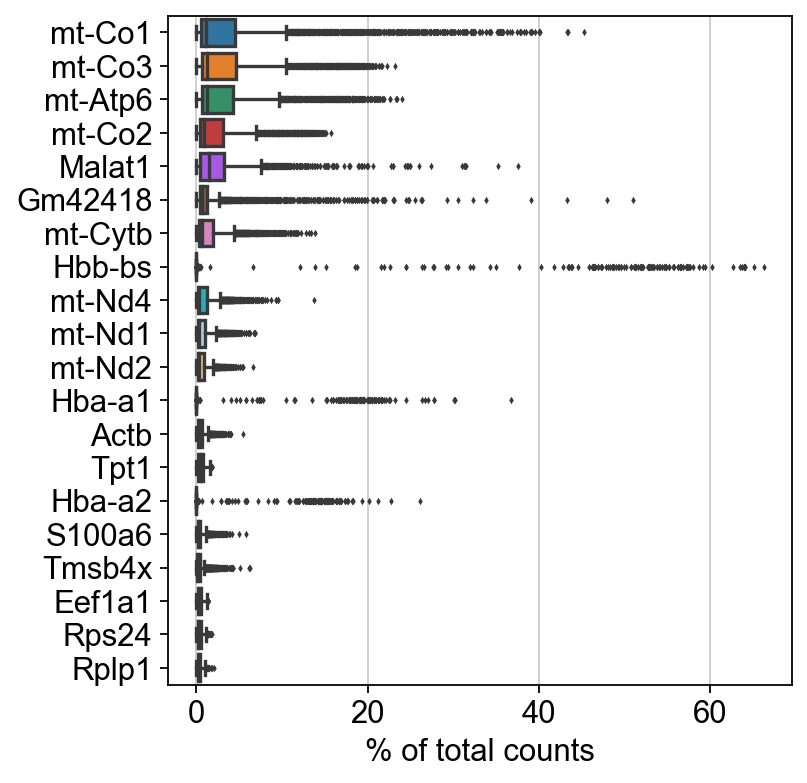

In [ ]:
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )
##expecteded to see Malat1 it's mitochondrial gene, and other mitochondrial genes also usually it can detect ribosomal genes and actin

In [ ]:
##filter out cells that has less that 200 genes and genes that expressed in less than 3 cells

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 201 cells that have less than 200 genes expressed
filtered out 13450 genes that are detected in less than 3 cells


C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata.var['mt']=adata.var_names.str.startswith('mt-')##make new column with mitochondrial genes
adata.var

gene_id  n_cells     mt
Xkr4                      Xkr4       46  False
Gm19938                Gm19938       82  False
Sox17                    Sox17        7  False
Mrpl15                  Mrpl15     1222  False
Lypla1                  Lypla1     1155  False
...                        ...      ...    ...
Vamp7                    Vamp7      985  False
Spry3                    Spry3        6  False
Tmlhe                    Tmlhe      156  False
CAAA01147332.1  CAAA01147332.1      169  False
AC149090.1          AC149090.1     1741  False

[18835 rows x 3 columns]

In [ ]:
adata.var.mt.value_counts() ###Mitchondrial genes

False    18822
True        13
Name: mt, dtype: int64

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()##to remove the duplicates in var_names

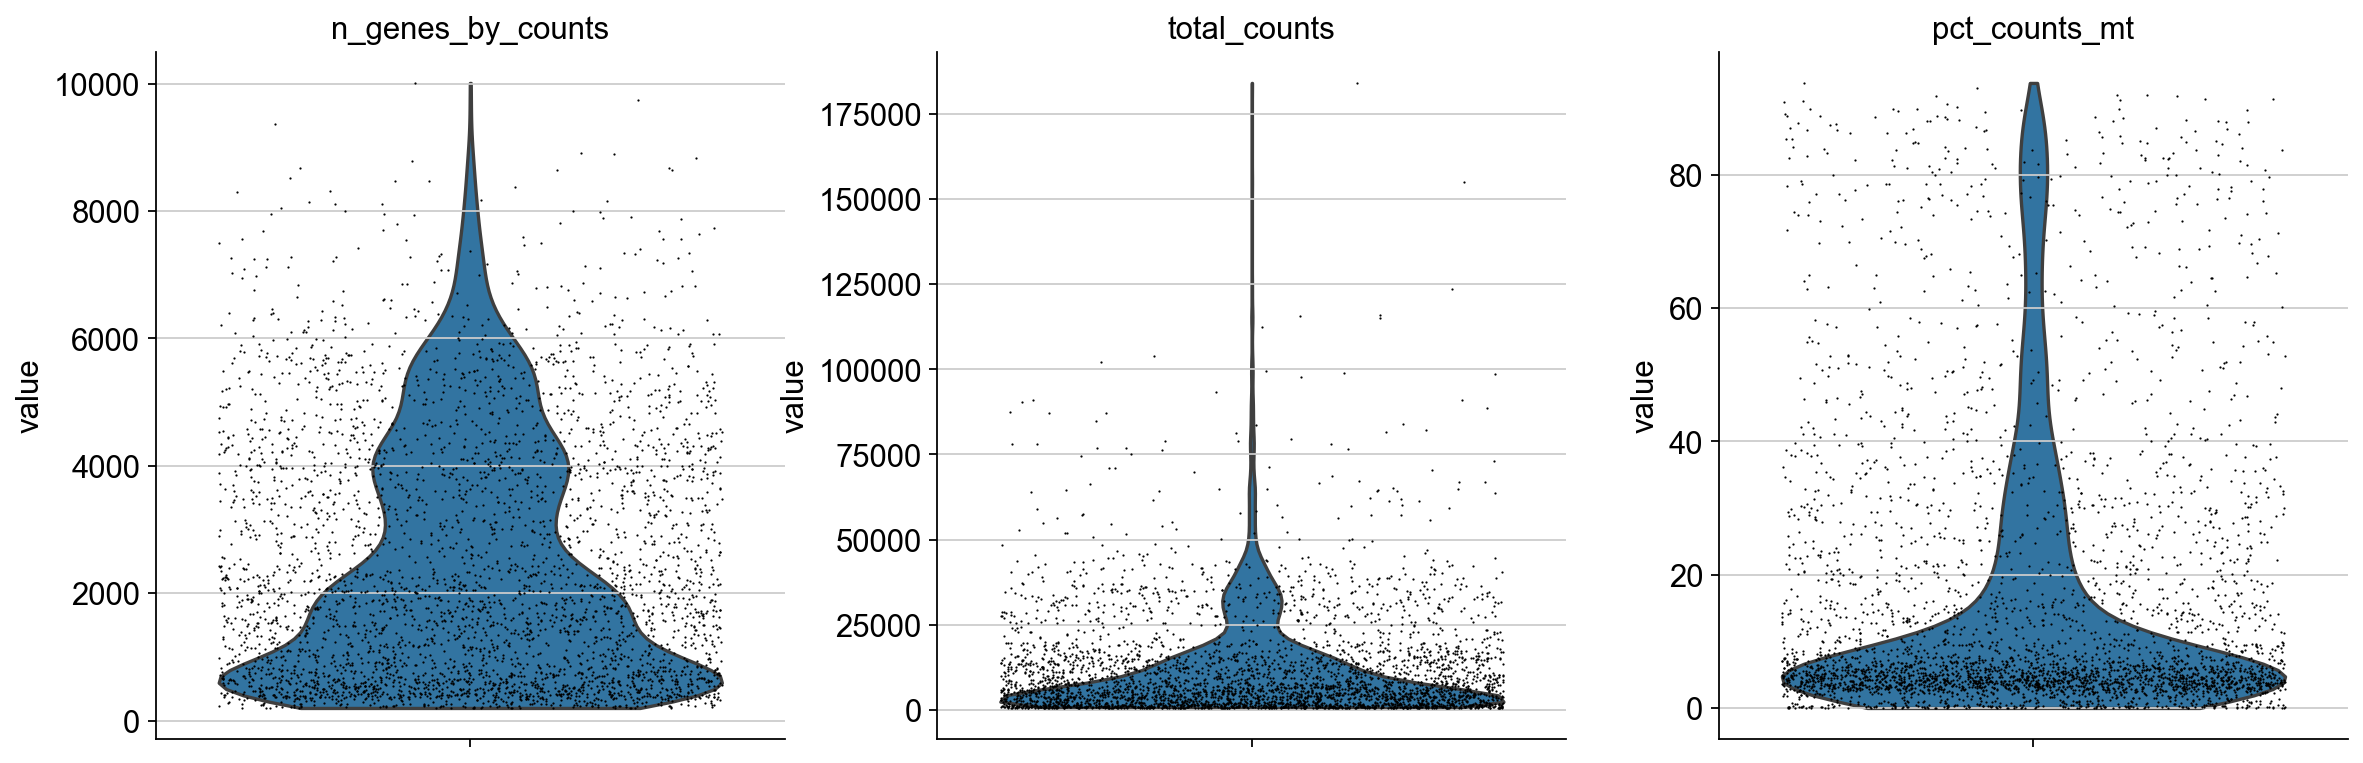

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts (to many total count might be douplets)

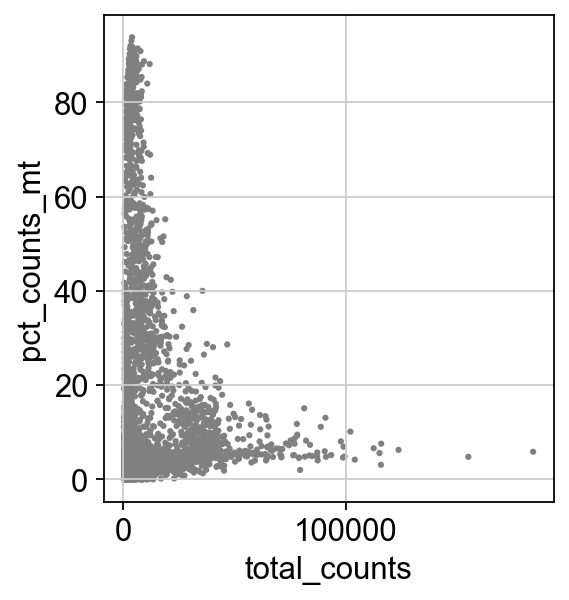

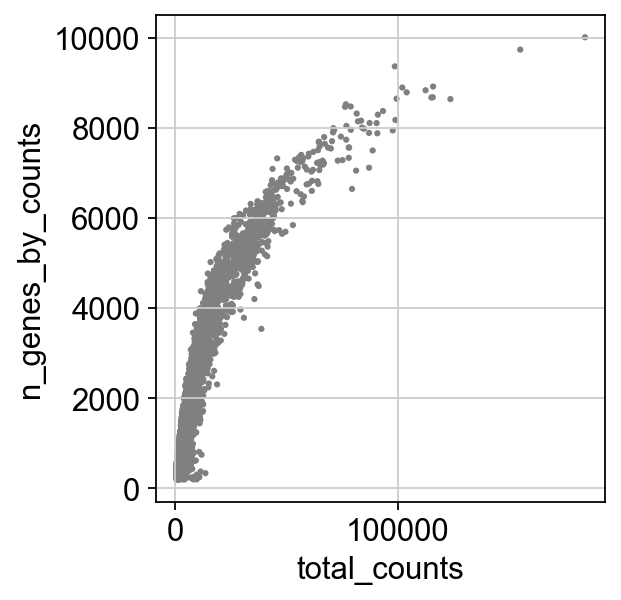

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
##filtering by slicing andata
adata = adata[adata.obs.n_genes_by_counts < 8500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

# Normalization

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)##library size correction

normalizing counts per cell


C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [ ]:
#Logarithmize the data , to avoid having zeros in our matrix
sc.pp.log1p(adata)

In [ ]:
#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


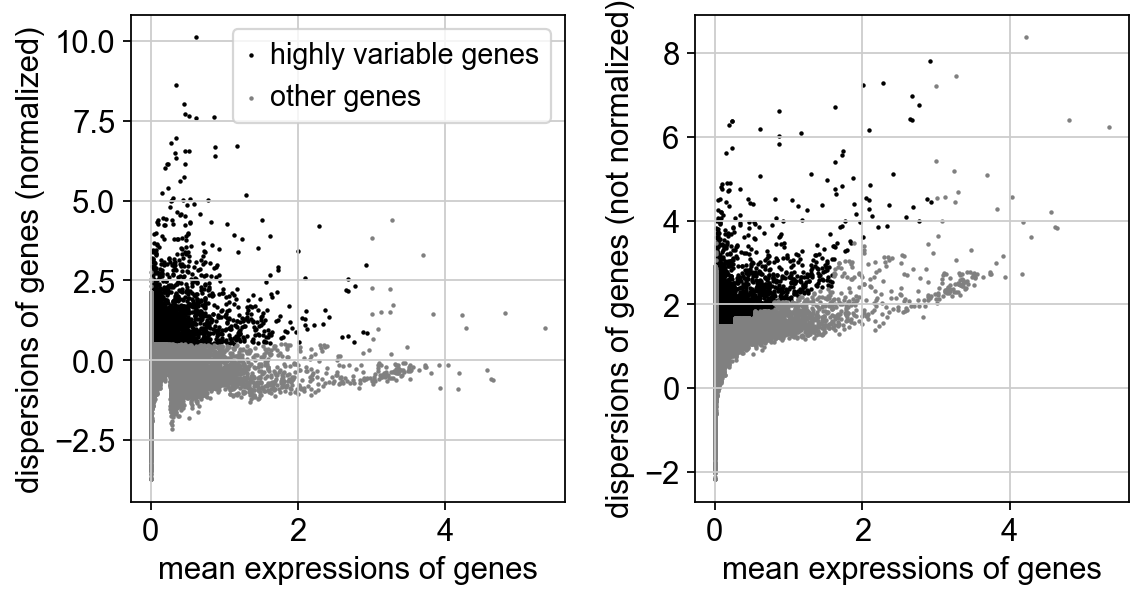

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var.highly_variable.value_counts()

False    14320
True      4515
Name: highly_variable, dtype: int64

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, 'total_counts')#Regress out effects of total counts per cell

regressing out total_counts
    sparse input is densified and may lead to high memory use
    finished (0:00:21)


In [ ]:
##PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


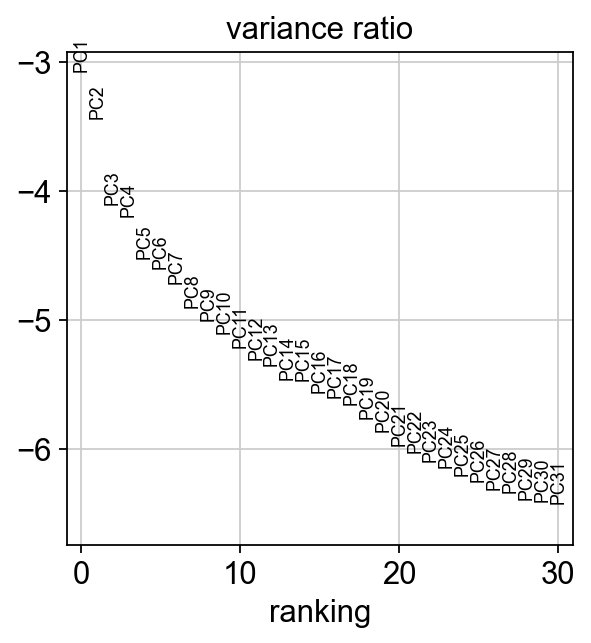

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=23, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [ ]:
#Embedding the neighborhood graph
sc.tl.leiden(adata)
sc.tl.paga(adata)


running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [ ]:
sc.tl.umap(adata)##use paga to imporve the conectivity between the clusters as umap encurage forming clusters which might shatter trajectories

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


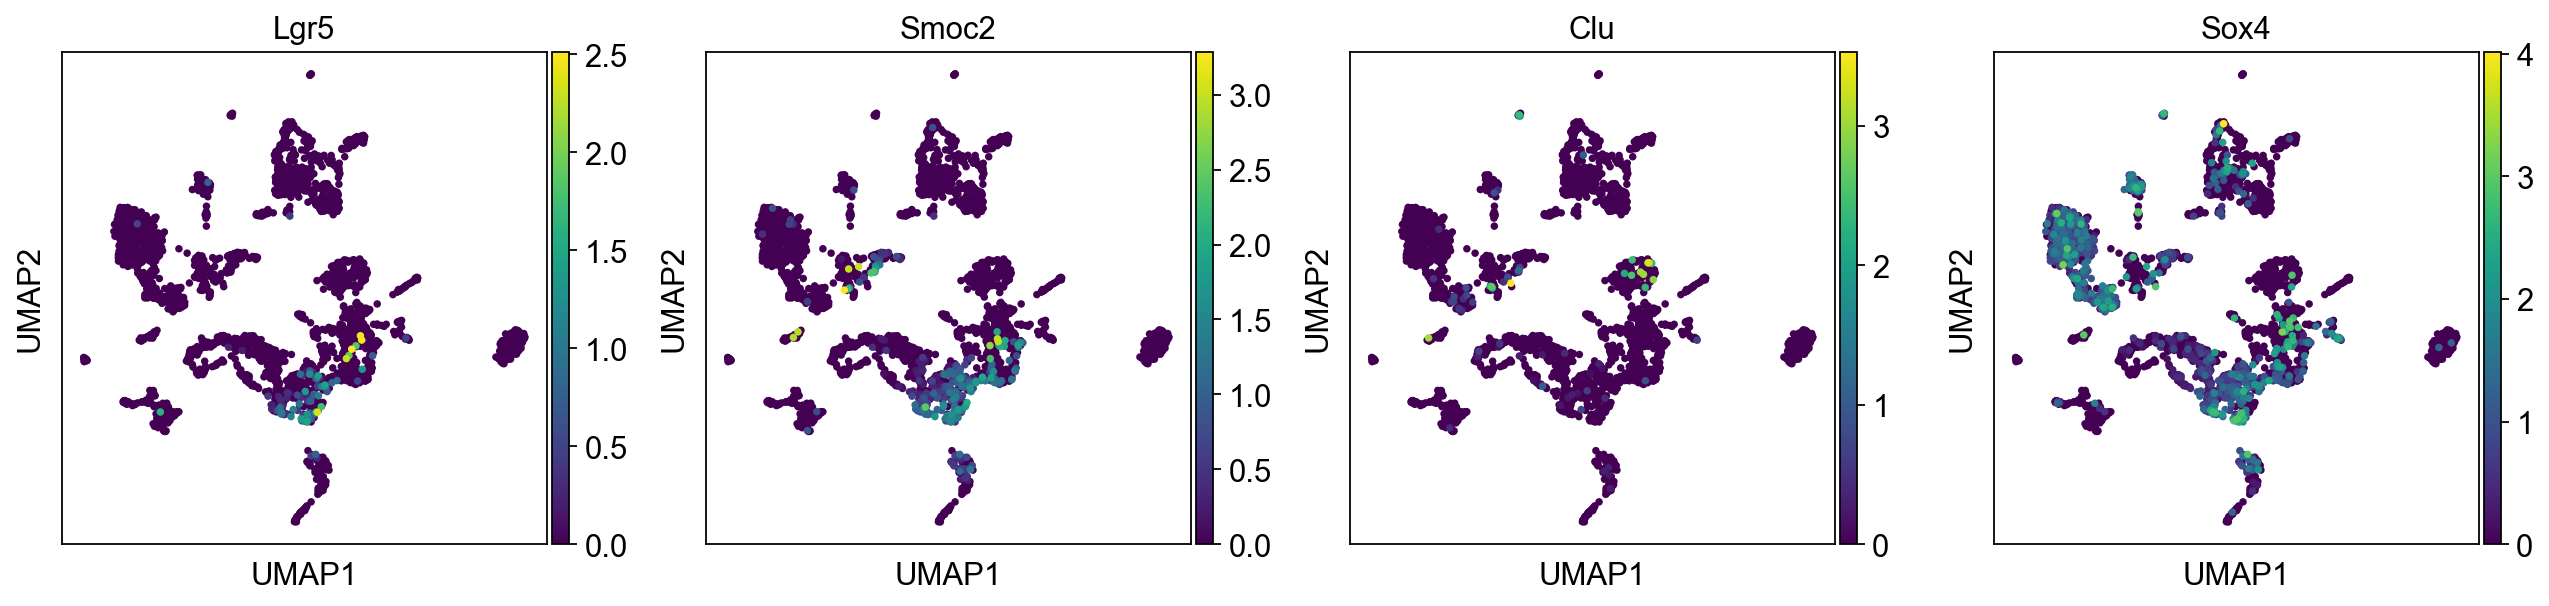

In [ ]:
##stem cells markers ,clu is not agreat markers for stem cells
sc.pl.umap(adata, color=['Lgr5', 'Smoc2', 'Clu','Sox4'])

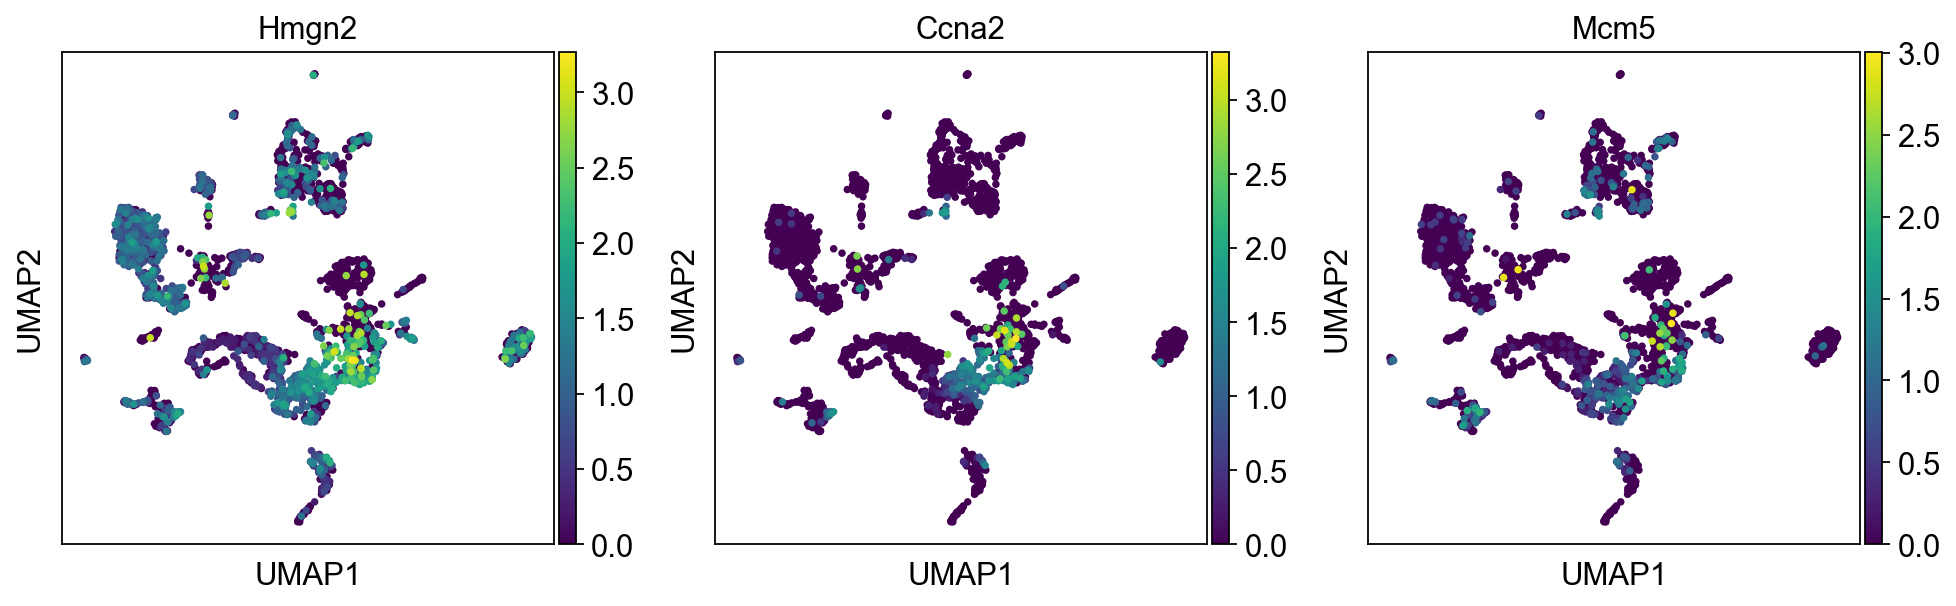

In [ ]:
##TA cells (trans-amplifying cell markers)
sc.pl.umap(adata, color=['Hmgn2', 'Ccna2', 'Mcm5'])

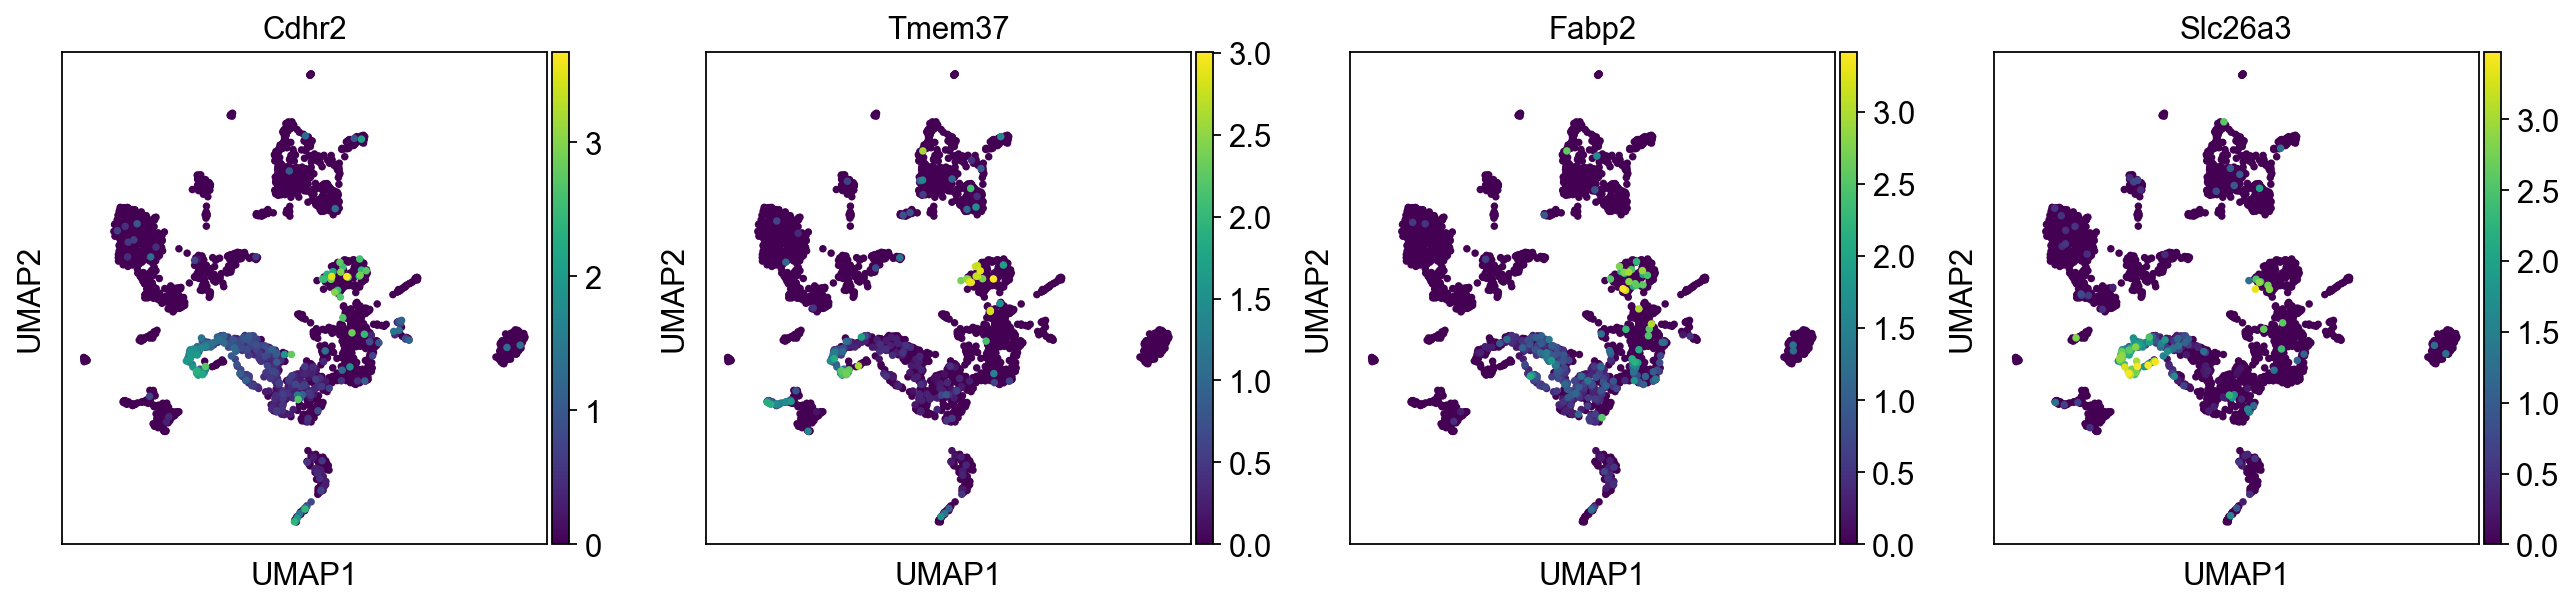

In [ ]:
sc.pl.umap(adata, color=['Cdhr2', 'Tmem37', 'Fabp2','Slc26a3'])##enterocytes markers

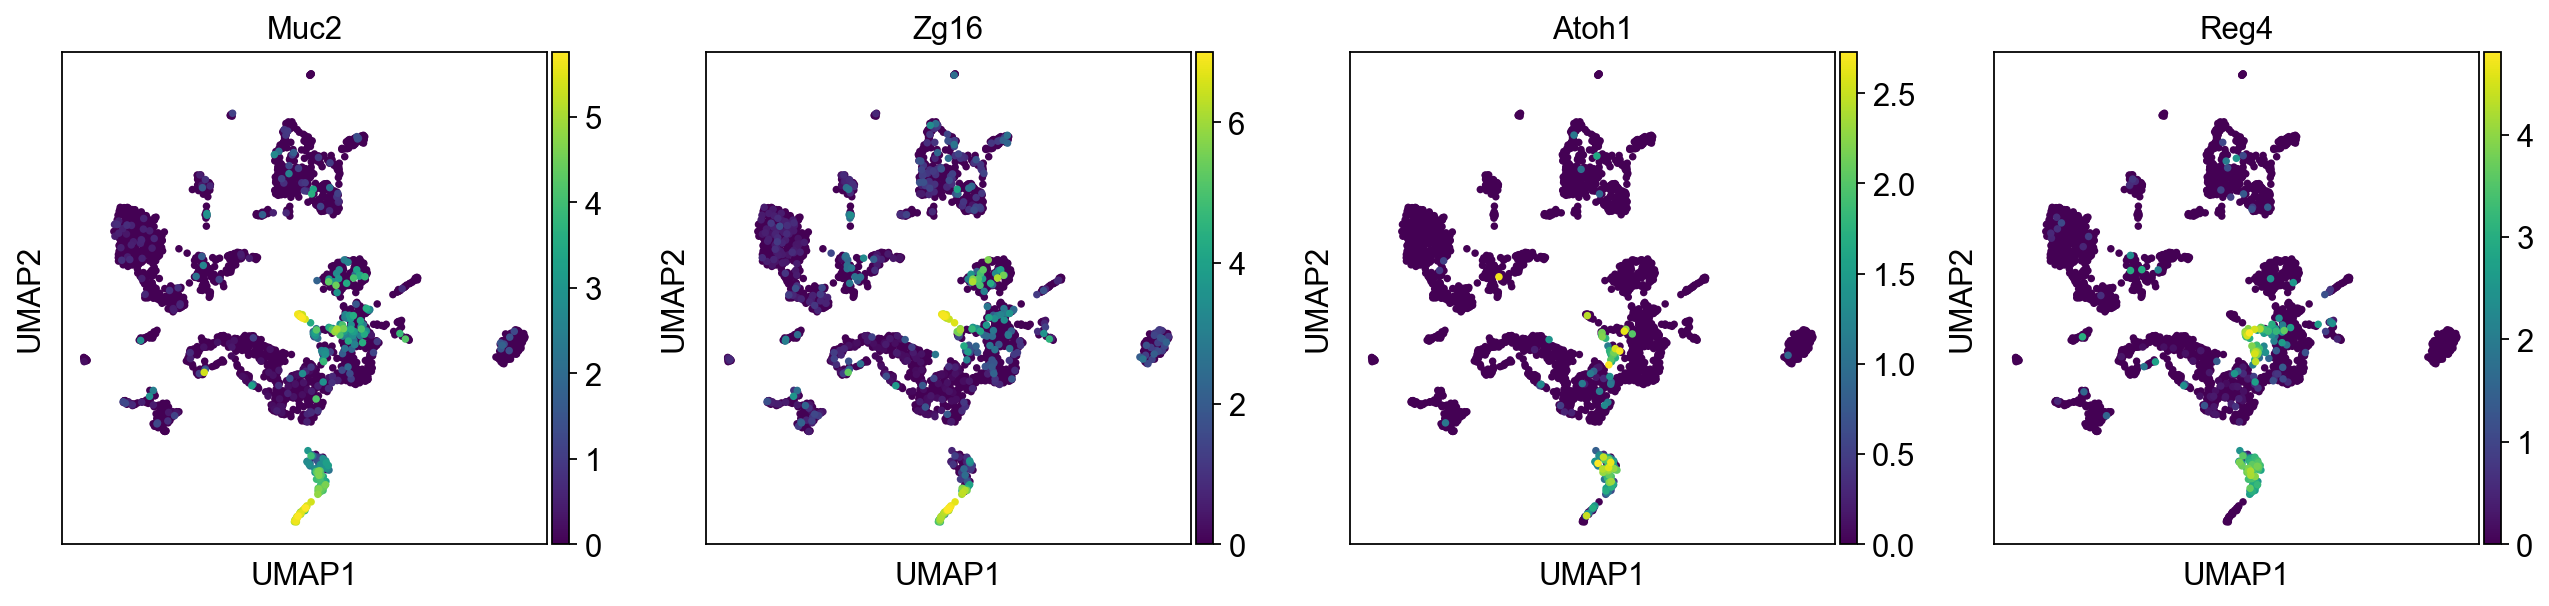

In [ ]:
sc.pl.umap(adata, color=['Muc2', 'Zg16', 'Atoh1','Reg4'])###goblet marker (secretory cells)

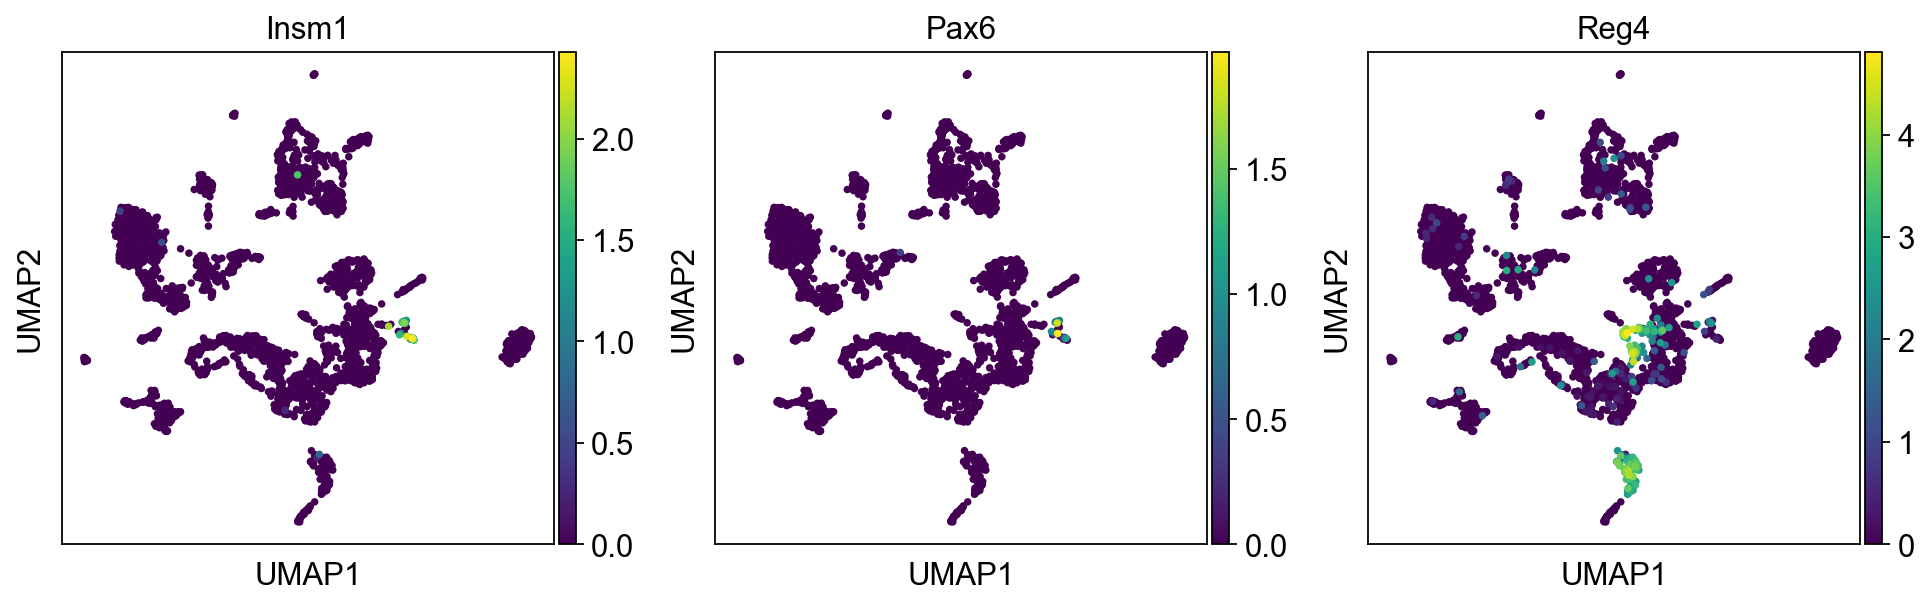

In [ ]:
sc.pl.umap(adata, color=['Insm1', 'Pax6','Reg4'])##EEC marker secretory cells markers, Reg4 is a general secretory marker which can be present in Goblet and EEC

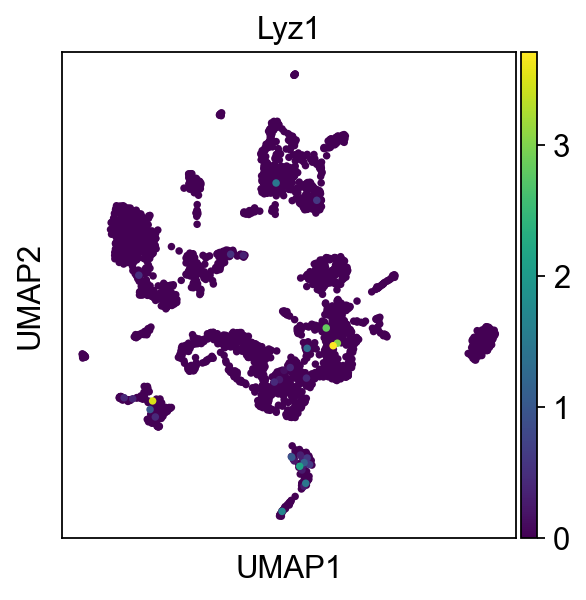

In [ ]:
sc.pl.umap(adata, color=['Lyz1'])##it's for paneth cell markers, which not commonly present in colon cells, this result makes sense

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


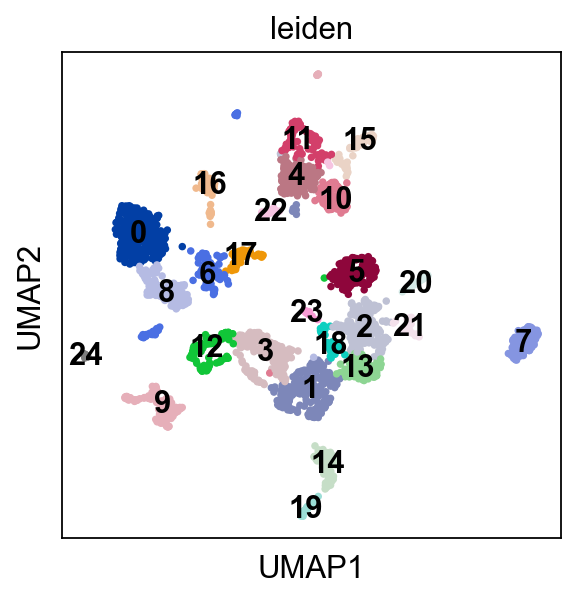

In [ ]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

In [ ]:
##keep only epithelial cells
adata.obs['leiden']
adata_=adata[adata.obs['leiden'].isin(['5', '20', '2','3','1','12','13','18','23','21','14','19']),:]

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


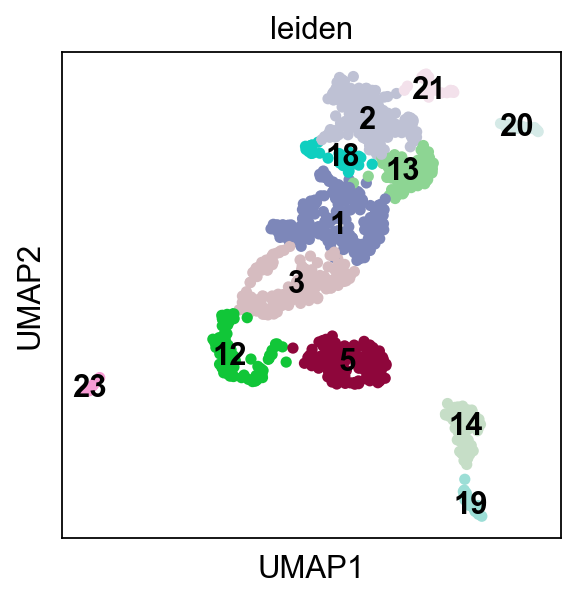

In [ ]:
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


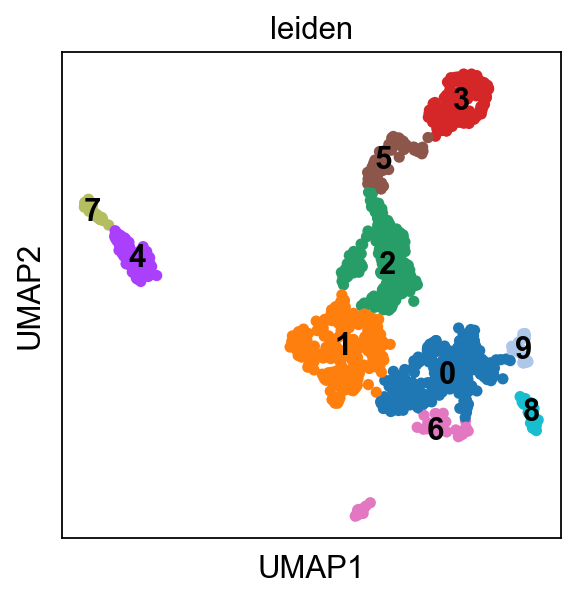

In [ ]:
#Embedding the neighborhood graph##reclustering with leiden and resolution 0.2
sc.tl.leiden(adata_,resolution=0.2)
sc.tl.umap(adata_)
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

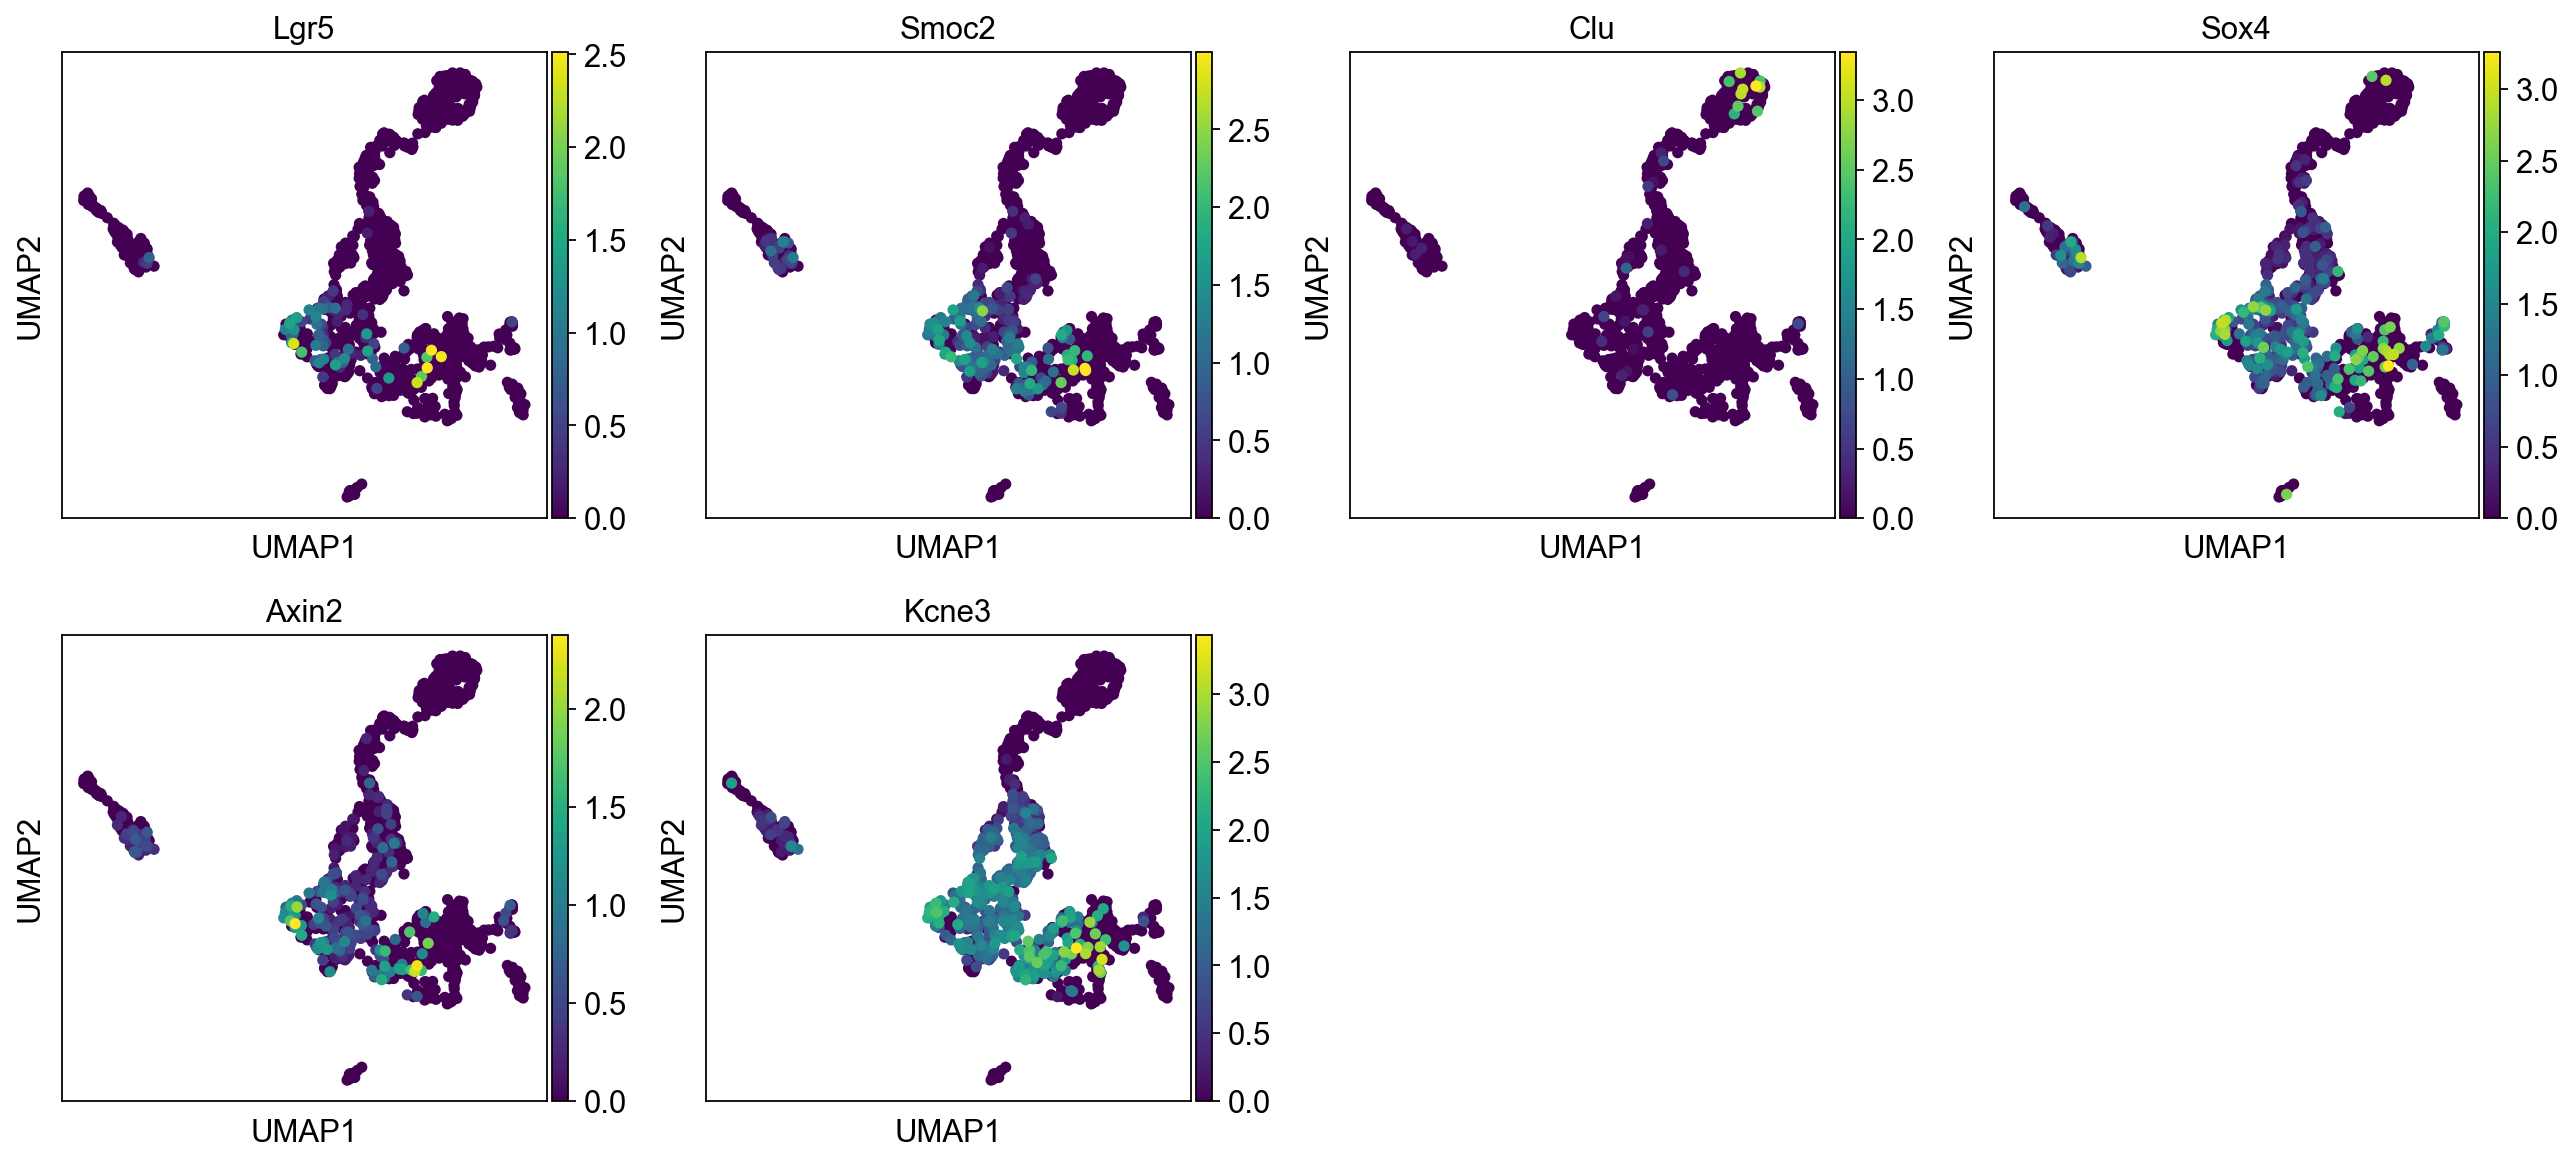

In [ ]:
##stem cells, Clu is not great makers, Sox4 can be in both stem cells and trans-amplifying cells
sc.pl.umap(adata_, color=['Lgr5', 'Smoc2', 'Clu','Sox4','Axin2','Kcne3'])##cluster

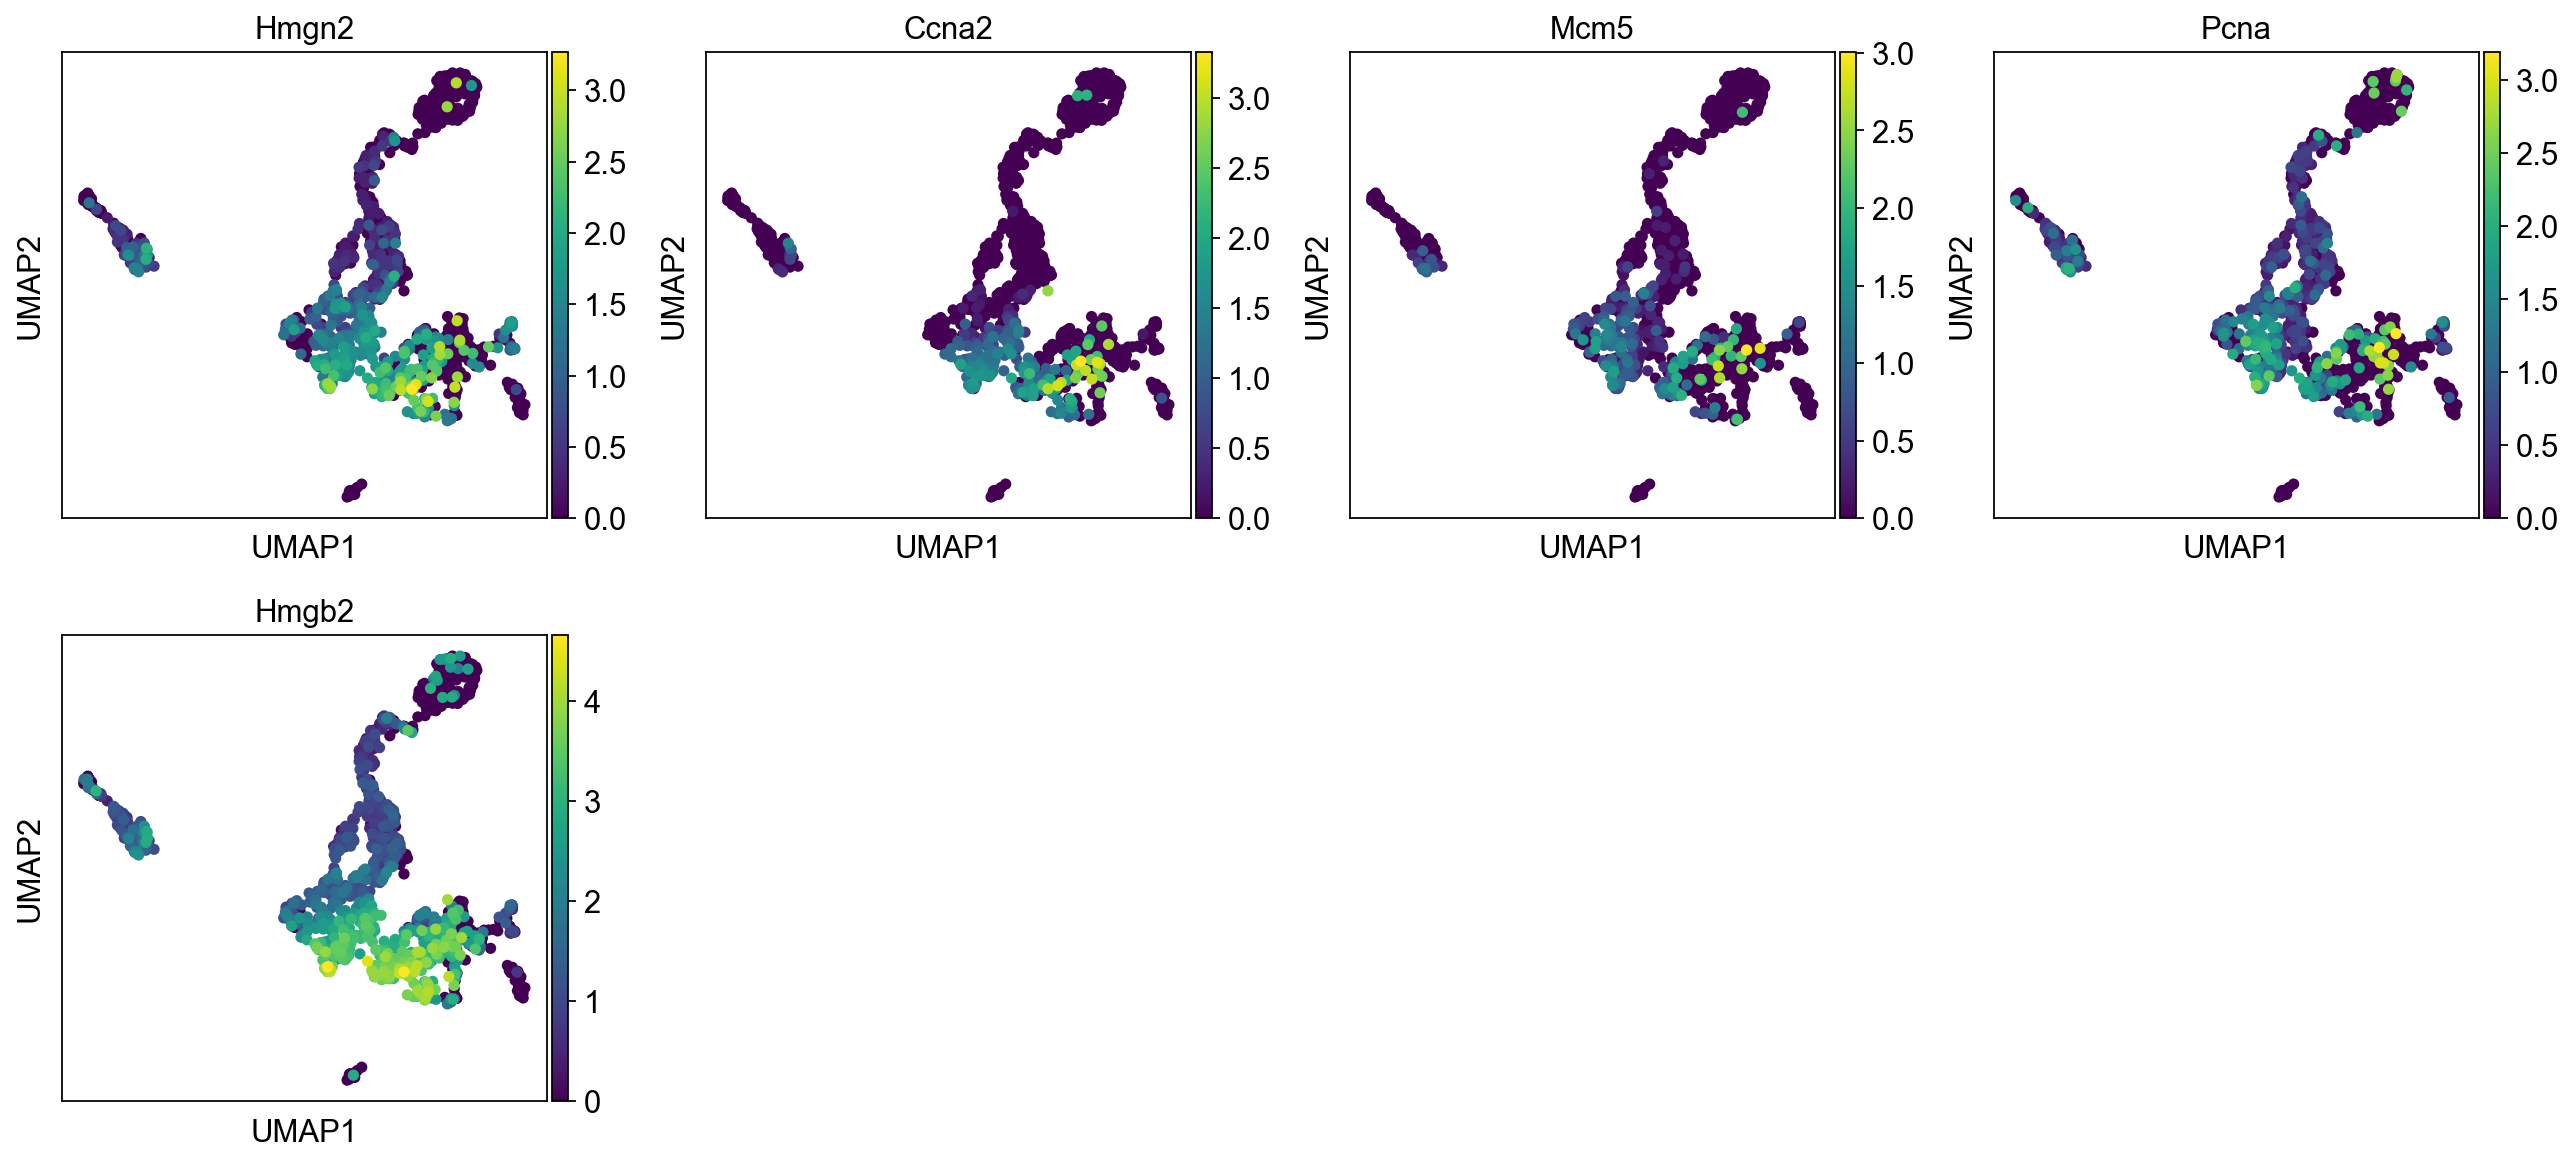

In [ ]:
##TA cells,, trans-amplifying cells (near stem cells)
sc.pl.umap(adata_, color=['Hmgn2', 'Ccna2', 'Mcm5','Pcna','Hmgb2'])

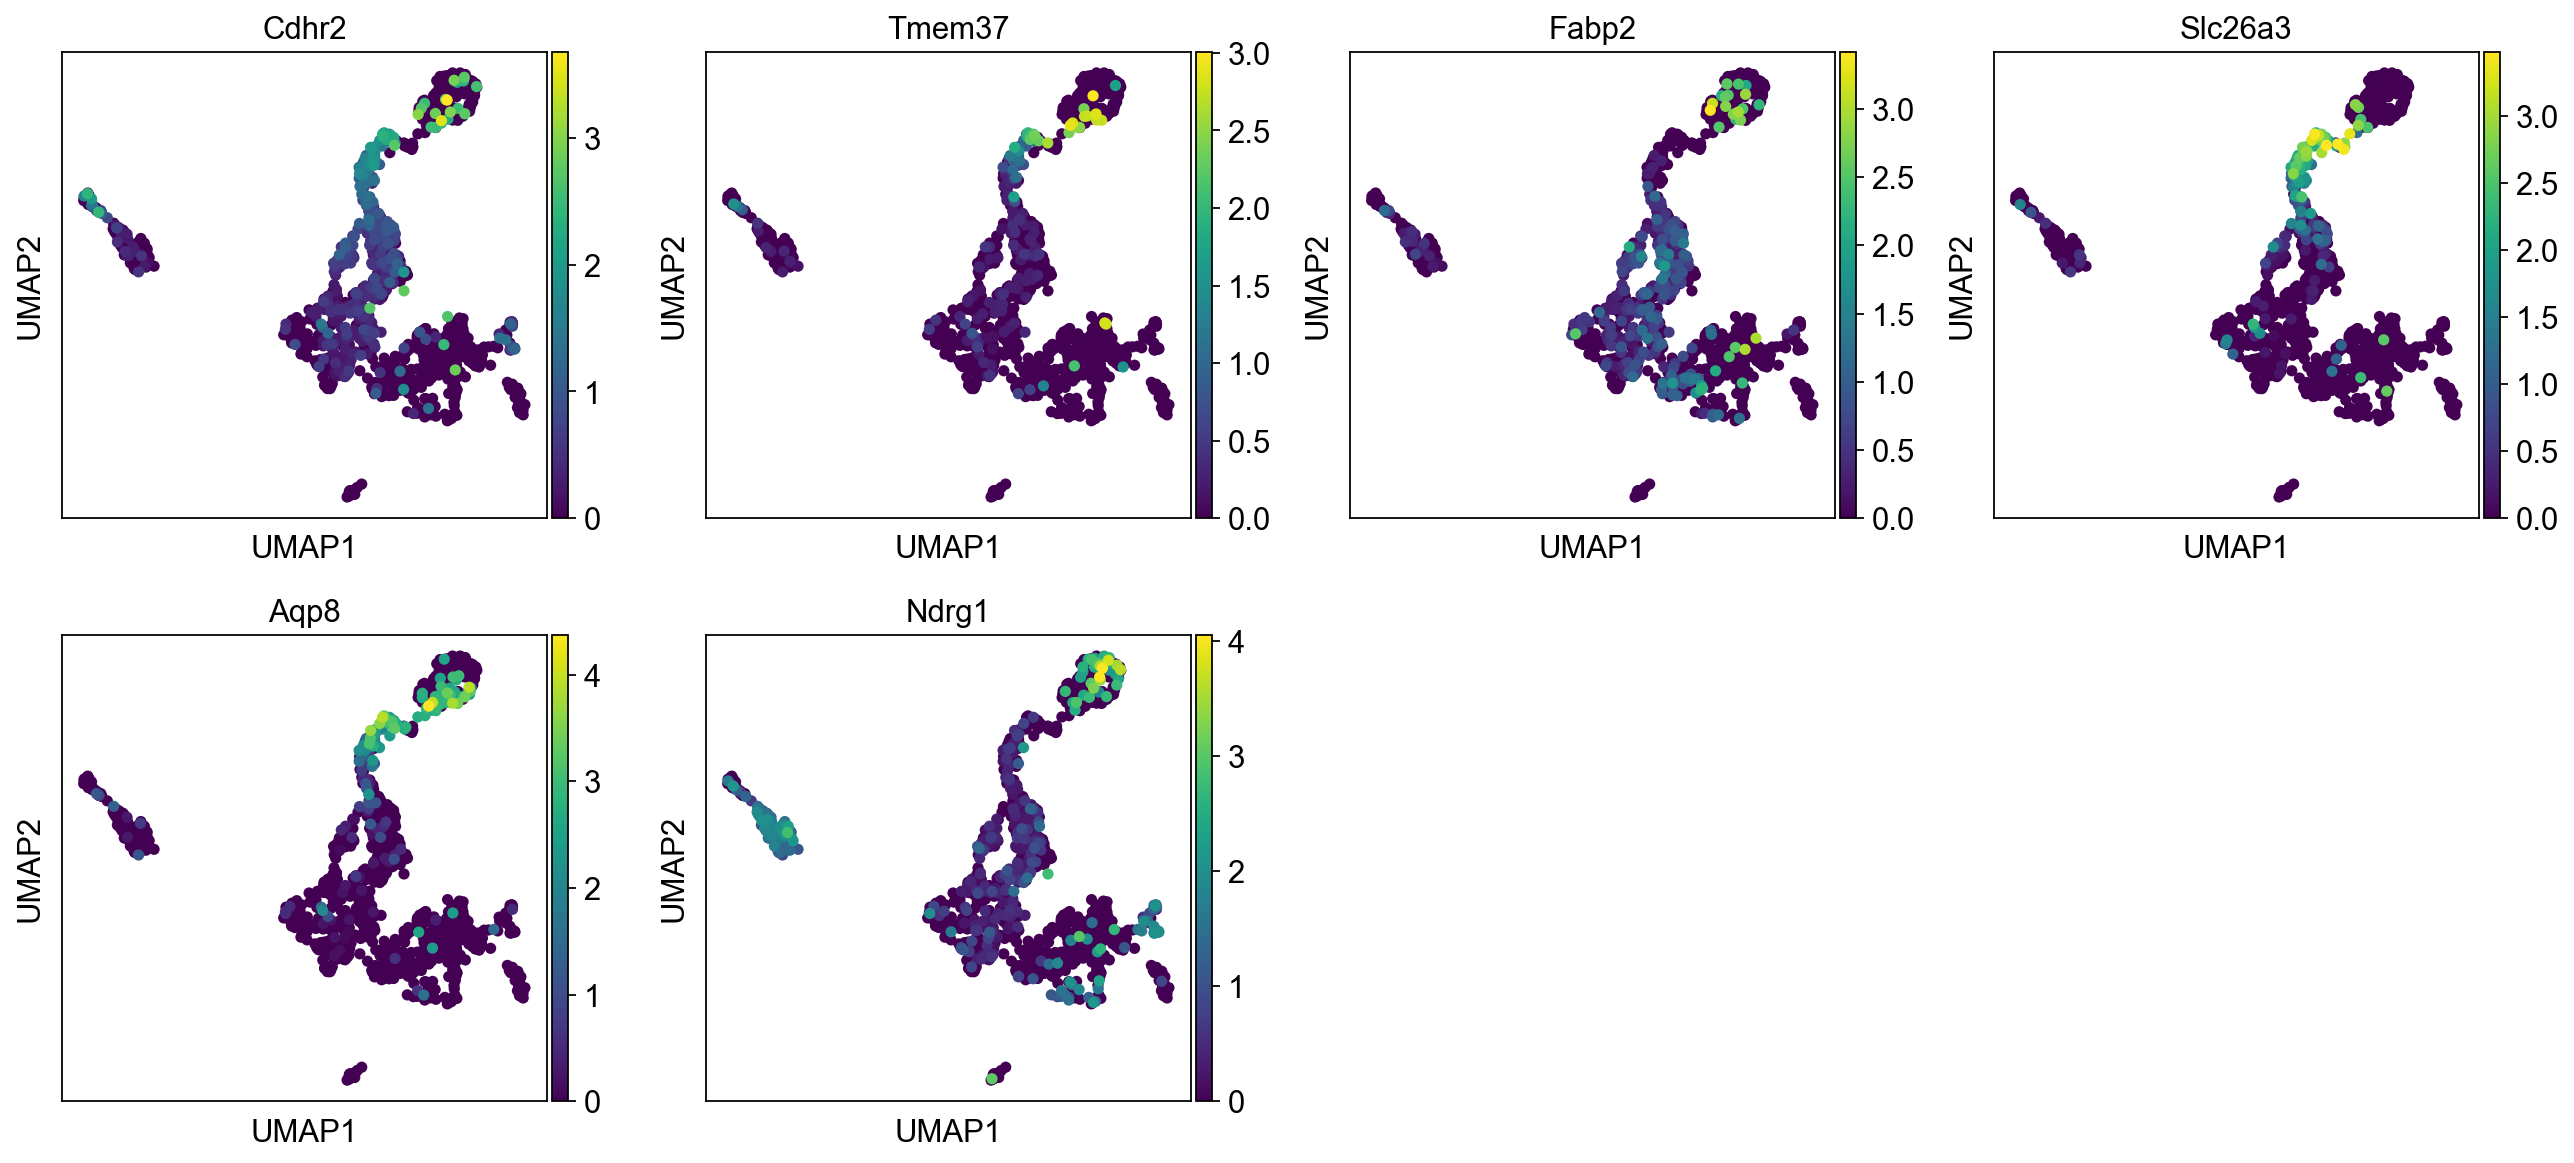

In [ ]:
sc.pl.umap(adata_, color=['Cdhr2', 'Tmem37', 'Fabp2','Slc26a3','Aqp8','Ndrg1'])##enterocytes, Slc26a3 is localized in the early enterocytes (enterocytes progenitors)

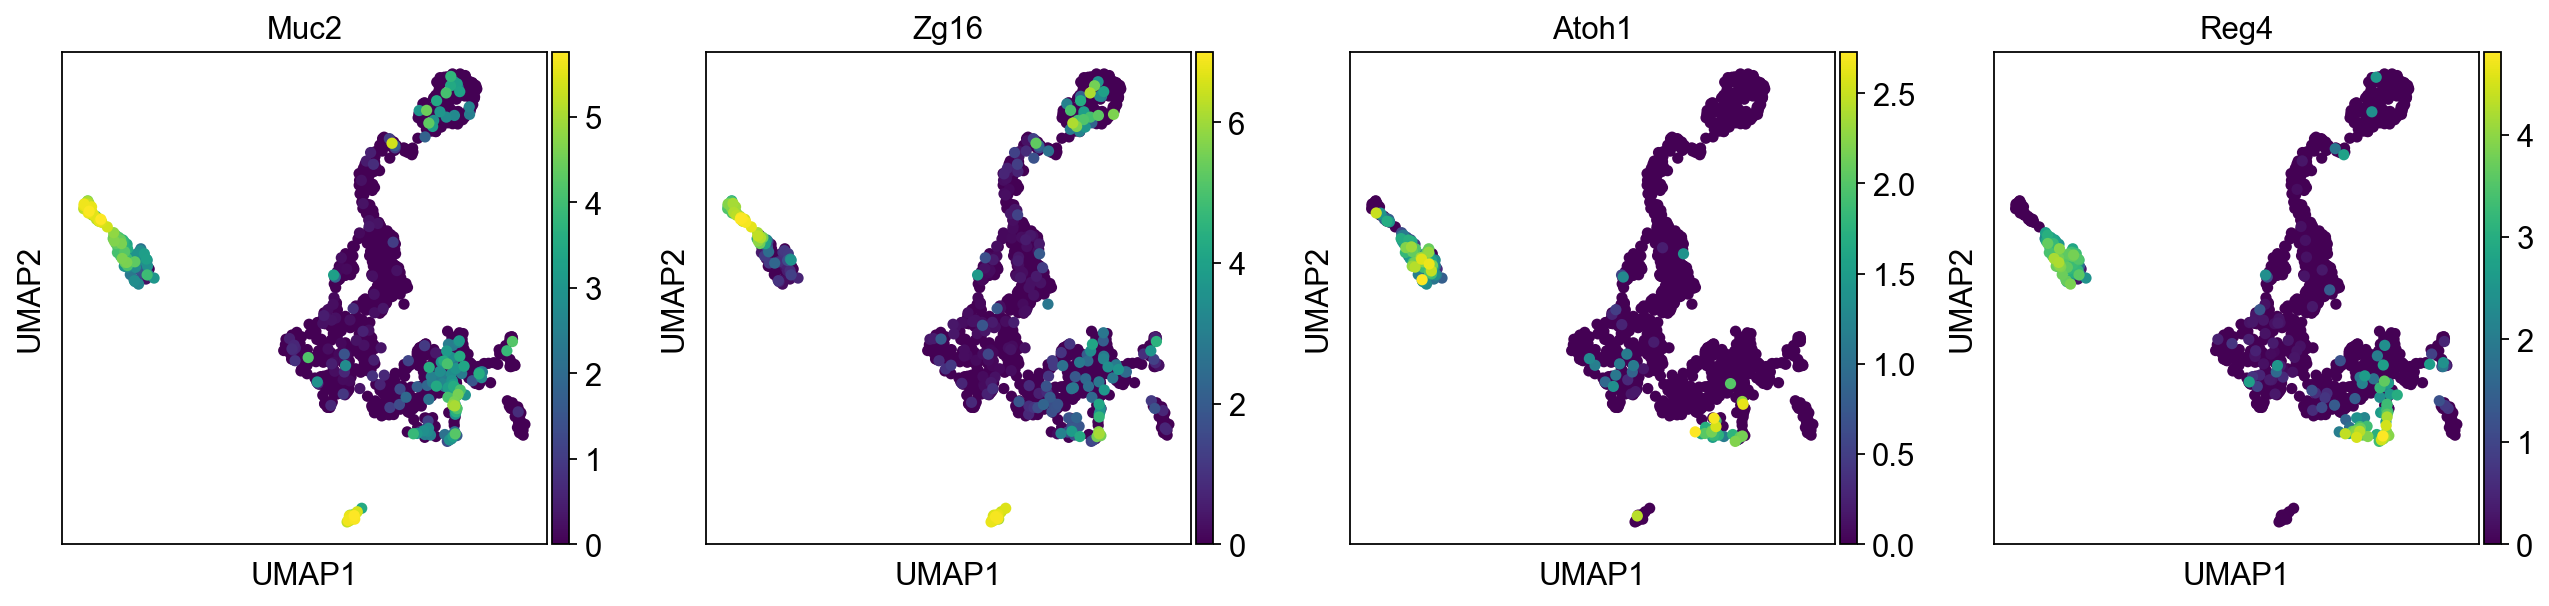

In [ ]:
sc.pl.umap(adata_, color=['Muc2', 'Zg16', 'Atoh1','Reg4'])###goblet marker

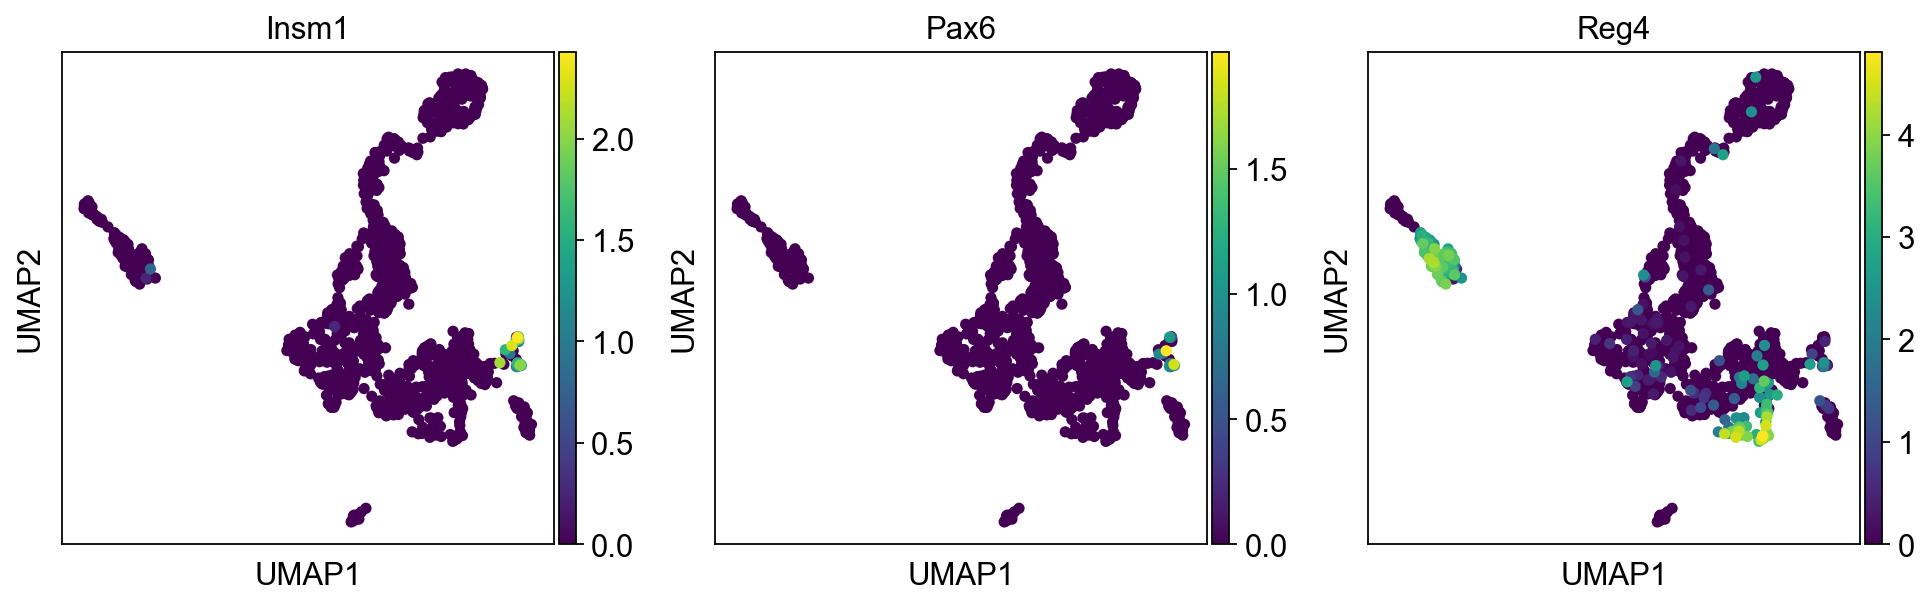

In [ ]:
sc.pl.umap(adata_, color=['Insm1', 'Pax6','Reg4'])##EEC marker
#Reg4 is a general secretory marker which can be present in Goblet and EEC

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Stem cells',
     '1': 'TA',
     '2': 'TA2',
     '3': 'EC2',
     '4': 'GC2',
     '5': 'EC',
     '6': 'GC',
     '7': 'GC2',
     '8': 'Unknown',
     '9': 'EEc'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_.obs['cell type'] = adata_.obs['leiden'].map(cluster2annotation).astype('category')

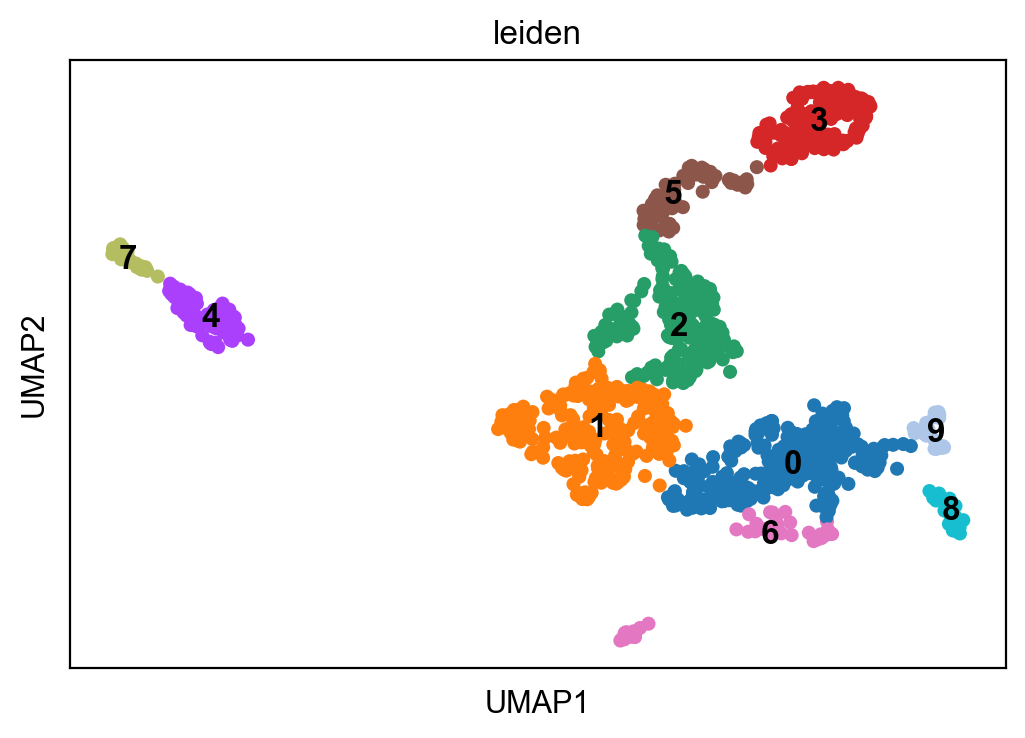

In [ ]:
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

In [ ]:
adata_.write_h5ad('adata.h5ad')

# RNA velocity

In [ ]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.10.4) on 2023-04-09 17:23.


In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
Mock = scv.read('MOCK.loom', cache=True)##it has unspliced matrix

... writing an h5ad cache file to speedup reading next time


In [ ]:
scv.utils.clean_obs_names(adata_)##you have to clean the obs.name to make the cell ID matching each other
scv.utils.clean_obs_names(Mock)

In [ ]:
merged=scv.utils.merge(adata_, Mock)##merg with the preprocessed data
merged

AnnData object with n_obs × n_vars = 1171 × 4515
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

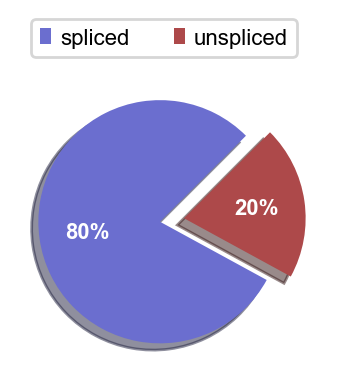

In [ ]:
scv.pl.proportions(merged)##20% of the RNA are unspliced

# Preprocess the Data

In [ ]:
adata=merged.copy()
adata

AnnData object with n_obs × n_vars = 1171 × 4515
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [ ]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
scv.pp.log1p(adata)

Filtered out 623 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [ ]:
# first and second order moments (means and uncentered variances) computed among nearest neighbors
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Estimate RNA velocity

In [ ]:
##Dynamical Model to  learn the full transcriptional dynamics of splicing kinetics
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/12 cores)


  0%|          | 0/773 [00:00<?, ?gene/s]

    finished (0:01:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [ ]:
##calculate RNA velocity
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/1171 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
adata.write('Mock.h5ad')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


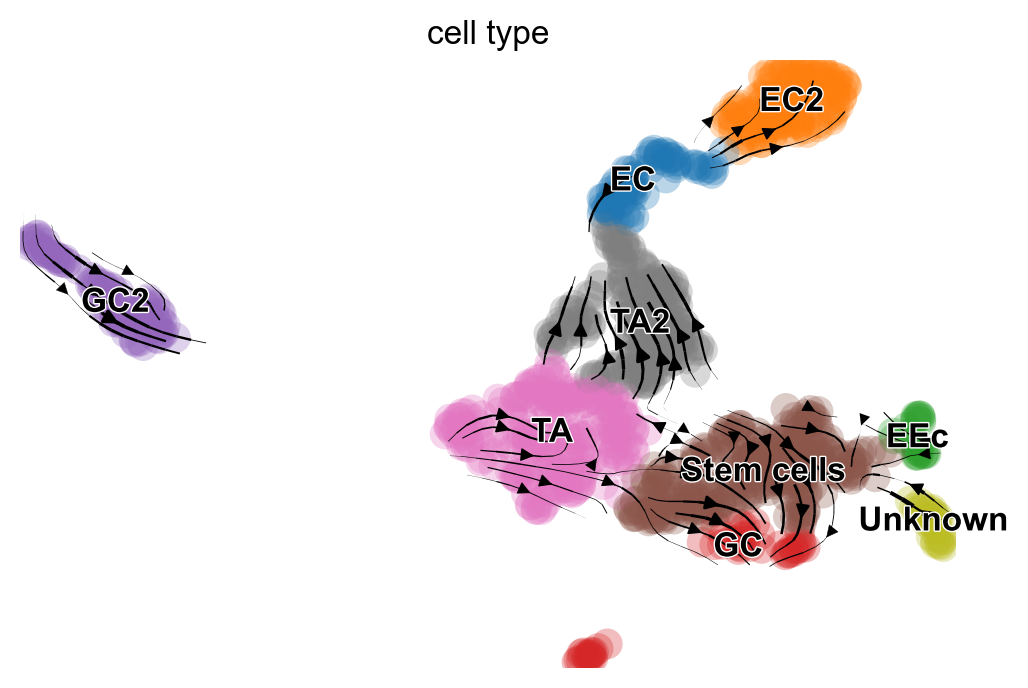

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cell type')

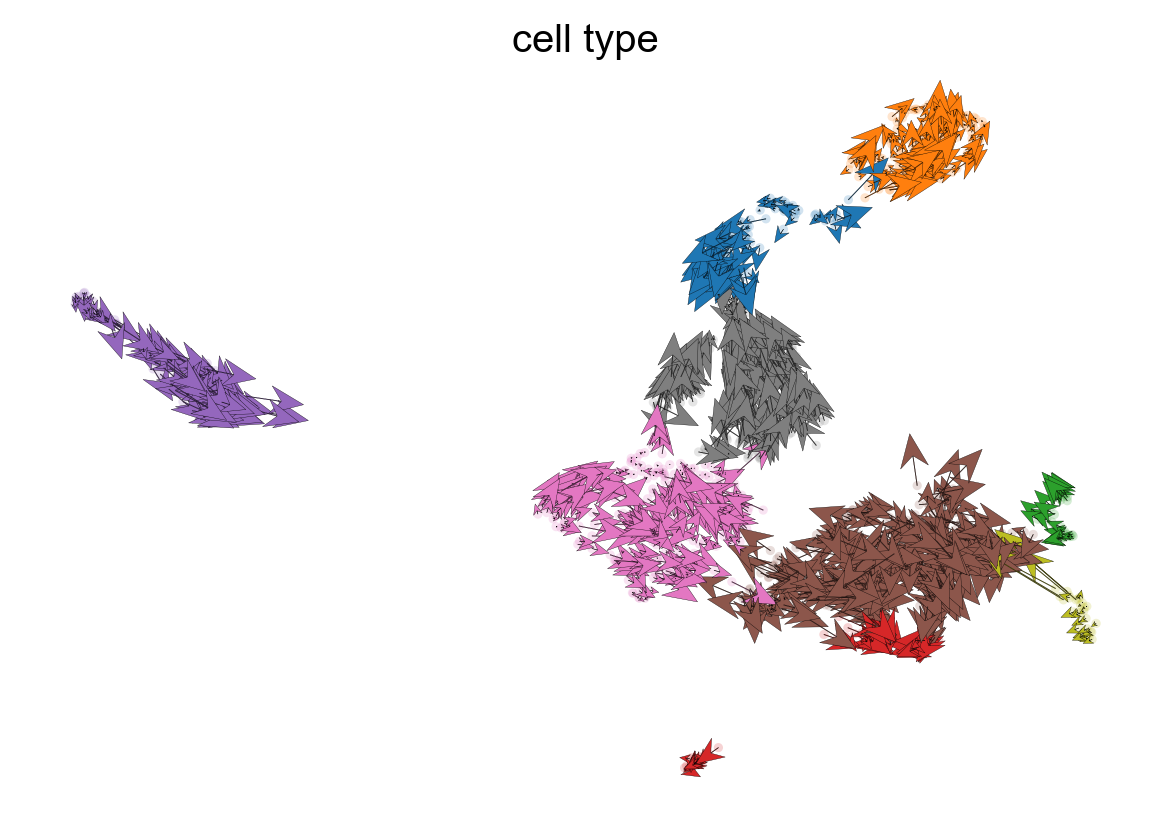

In [ ]:
scv.pl.velocity_embedding(adata, arrow_length=5, arrow_size=5, dpi=120,color='cell type')

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Mat

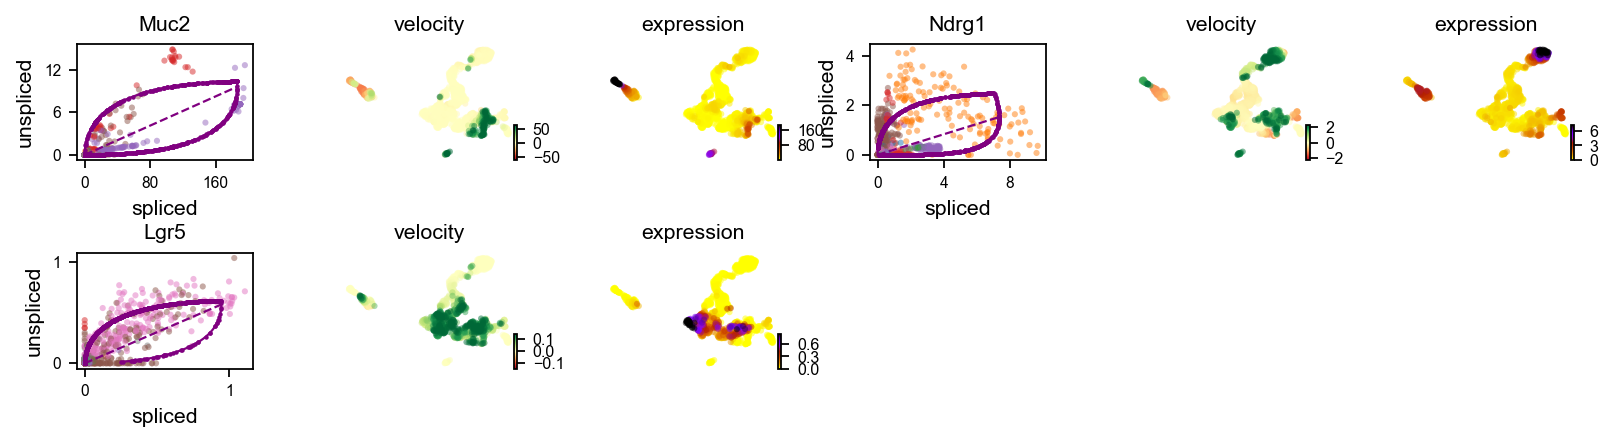

In [ ]:
scv.pl.velocity(adata, ['Muc2',  'Ndrg1', 'Lgr5'], ncols=2,color='cell type')
##Muc2 is for Goblet cells, Ndrg1 for differentiated cells enterocytes and secretory (goblet and EEC), Lgr5 for stem cells

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


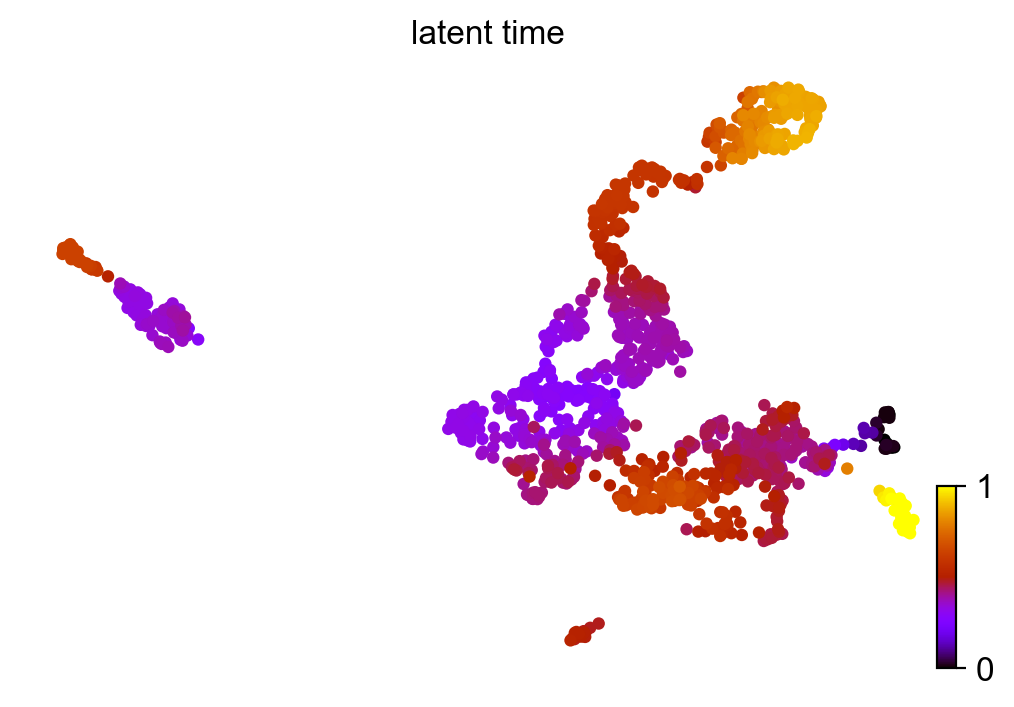

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)


# Identifying Cluster-specific top-likelihood genes (potenial driver)

In [ ]:
scv.tl.rank_dynamical_genes(adata, groupby='cell type')
df_ = scv.get_df(adata, 'rank_dynamical_genes/names')

ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


In [ ]:
df_.to_csv('potenial driver.csv')

In [ ]:
adata.layers['spliced']

<1171x1701 sparse matrix of type '<class 'numpy.float32'>'
	with 434116 stored elements in Compressed Sparse Row format>

In [ ]:
adata.layers['unspliced']

<1x1701 sparse matrix of type '<class 'numpy.float32'>'
	with 25 stored elements in Compressed Sparse Row format>

In [ ]:
df_.head(10)

EC        EC2     EEc        GC       GC2 Stem cells       TA  \
0   Prss30  Serpinb6b  Sez6l2     Fcgbp     Capn9    Tmem45b    Muc13   
1  Slc37a2      Klra7  Kcnmb2     Ptprr  Ccnb1ip1      Gna14    Sgo2a   
2   Nlrp9b      Fstl1     Cpe      Plk1    Ahnak2      Hells   Iqgap3   
3   Guca2a       Ly6m   Gfra3     Sval1    Fer1l6       Kif4  Depdc1a   
4  Sectm1b    Adamts4    Chga     Kif11   Gadd45a     Ccdc34    Cdca8   
5     Tgm3      Ethe1    Tph1    Nusap1      Klf2       Lgr5    Runx3   
6    Fkbp5       Cd34  Tm4sf4  Hepacam2   Cyp2d12      Muc13    Kif15   
7    Mep1b      Postn  Pappa2     Hgfac     Ddx60       Agr2    Bace2   
8    Myh14     Lgals3   Ptprn    Ttc39a     Foxa3      Cep55     Hmmr   
9    Mep1a      Loxl1  Snap25     Chek2     Fcgbp      Kif11     Tpx2   

       TA2 Unknown  
0    Tnni1   Alas2  
1  Cyp2c68    Bpgm  
2    Myh14    Cdr2  
3     Tgm3    Lad1  
4   Mgat4a    Tsr1  
5   Lgals3  Rangrf  
6    Ethe1   Gsta3  
7     Sycn  Slc1a5  
8    Mef2c    Gatm  
9   Guca2a   Ccl24

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Mat

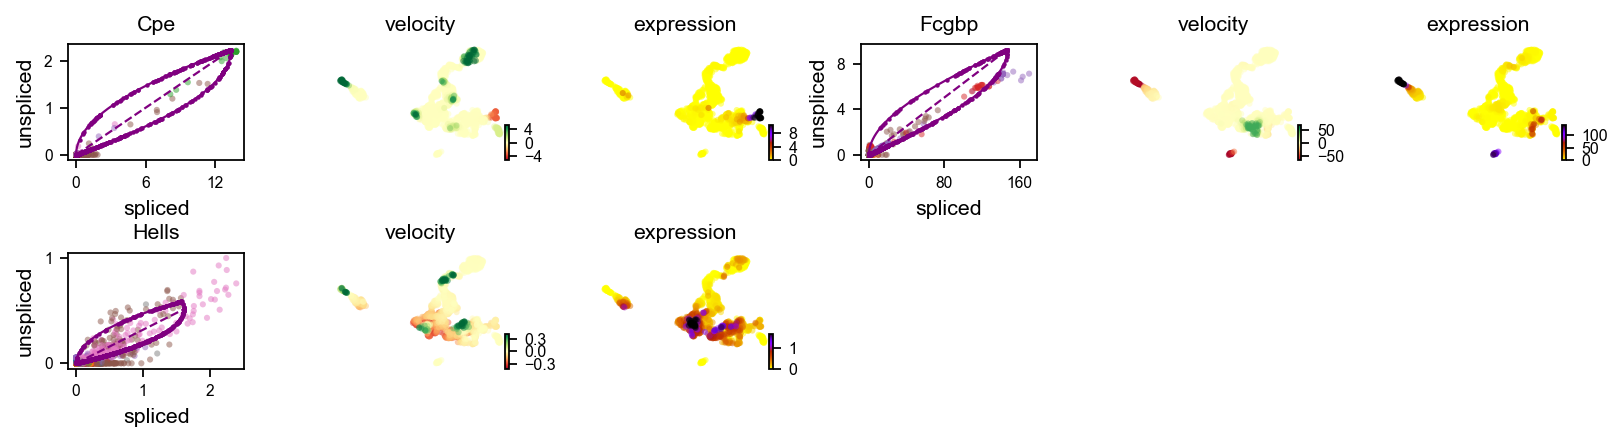

In [ ]:
scv.pl.velocity(adata, ['Cpe',  'Fcgbp', 'Hells'], ncols=2,color='cell type')

# calculate genes have cluster-specific differential velocity expression

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='cell type', min_corr=.3)

ranking velocity genes


C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\tools\utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [ ]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12500\430955543.py:1: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])


EC       EC2     EEc       GC    GC2 Stem cells      TA     TA2  \
0   Cyp2d34    Clca3b  Mettl6  Cracr2a   Ctsc     Rab11a   Fgfr4  Abcb1a   
1  Mgam2-ps      Mxd1  Ccdc34    Cenpf   Cry2      Nxpe2   Stmn1  Slc4a4   
2    Ccdc68  Ceacam20   Txnip     Muc2  Adtrp      Sorl1  Mlxipl   Mrps6   
3      Emp1      Fut2  Cuedc1   Spink4  Abcg2      Top2a    Dpp4   Stk25   
4      Eps8   Zdhhc21  Sema4g  Fam193b  Hoxb9   Slc22a18  Gsdmc4    St14   

   Unknown  
0  Tm4sf20  
1     Cttn  
2     Cd38  
3  Cyp4f40  
4    Adtrp

In [ ]:
df.to_csv('cluster_differential_velocity.csv')

In [ ]:
adata.write('adata.h5ad')

# cell rank

import cellrank as cr givers importerror
##ImportError: cannot import name 'Iterable' from 'collections' (C:\Users\ahmed\miniconda3\envs\my_project\lib\collections\__init__.py)

In [ ]:
##this solve the error

import collections.abc
#cell rank needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [ ]:
import cellrank as cr

In [ ]:
adata=sc.read_h5ad('adata.h5ad')
adata

AnnData object with n_obs × n_vars = 1171 × 1701
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'cell type_colors', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_dyna

the directional information comes from RNA velocity, and it use this information to compute initial & terminal states as well as fate probabilities for the dynamical process

In [ ]:
adata.obs

cell_id  n_genes  n_genes_by_counts  total_counts  \
AAACCCAAGCGT  AAACCCAAGCGTCTGC-1      354                353         574.0   
AAACCCAAGTAC  AAACCCAAGTACCCTA-1     5246               5244       30166.0   
AAACGCTAGGGC  AAACGCTAGGGCTAAC-1     5276               5275       38955.0   
AAACGCTTCTTG  AAACGCTTCTTGAACG-1     7891               7887       87154.0   
AAAGGATAGGAT  AAAGGATAGGATATGT-1     1408               1408        3288.0   
...                          ...      ...                ...           ...   
TTTGATCGTCCG  TTTGATCGTCCGATCG-1     1182               1182        2904.0   
TTTGGAGTCTCT  TTTGGAGTCTCTCAAT-1     5416               5405       22165.0   
TTTGGTTGTACT  TTTGGTTGTACTGCCG-1     6180               6178       45186.0   
TTTGTTGCACAA  TTTGTTGCACAATGCT-1      387                387         524.0   
TTTGTTGGTCTG  TTTGTTGGTCTGATAC-1     1191               1188        2355.0   

              total_counts_mt  pct_counts_mt leiden   cell type sample_batch  \
AAACCCAAGCGT             47.0       8.188153      3         EC2       CTGC-1   
AAACCCAAGTAC           1448.0       4.800106      1          TA       CCTA-1   
AAACGCTAGGGC           3382.0       8.681812      7         GC2       TAAC-1   
AAACGCTTCTTG           4984.0       5.718613      1          TA       AACG-1   
AAAGGATAGGAT              1.0       0.030414      0  Stem cells       ATGT-1   
...                       ...            ...    ...         ...          ...   
TTTGATCGTCCG             11.0       0.378788      0  Stem cells       ATCG-1   
TTTGGAGTCTCT           1086.0       4.899617      9         EEc       CAAT-1   
TTTGGTTGTACT           3528.0       7.807728      2         TA2       GCCG-1   
TTTGTTGCACAA             31.0       5.916031      0  Stem cells       TGCT-1   
TTTGTTGGTCTG              8.0       0.339703      7         GC2       ATAC-1   

              initial_size_unspliced  initial_size_spliced  initial_size  \
AAACCCAAGCGT                      66                   438         438.0   
AAACCCAAGTAC                    6419                 23082       23082.0   
AAACGCTAGGGC                   10094                 30227       30227.0   
AAACGCTTCTTG                   23830                 65773       65773.0   
AAAGGATAGGAT                      94                  2732        2732.0   
...                              ...                   ...           ...   
TTTGATCGTCCG                      87                  2298        2298.0   
TTTGGAGTCTCT                   12632                 17122       17122.0   
TTTGGTTGTACT                   12354                 34224       34224.0   
TTTGTTGCACAA                      72                   375         375.0   
TTTGTTGGTCTG                    1810                  1746        1746.0   

                n_counts  velocity_self_transition    root_cells  \
AAACCCAAGCGT -626.630615                  0.741522  6.678869e-08   
AAACCCAAGTAC -553.377319                  0.636521  1.164323e-08   
AAACGCTAGGGC -427.527496                  0.085589  1.236428e-04   
AAACGCTTCTTG -383.112946                  0.480760  1.197734e-06   
AAAGGATAGGAT -639.511353                  0.161053  3.433464e-07   
...                  ...                       ...           ...   
TTTGATCGTCCG -633.769531                  0.141016  4.783419e-07   
TTTGGAGTCTCT -435.515900                  0.059714  1.000000e+00   
TTTGGTTGTACT -350.020203                  0.544685  1.111503e-08   
TTTGTTGCACAA -675.354370                  0.098963  8.539159e-08   
TTTGTTGGTCTG -444.320068                  0.081884  2.036554e-03   

                end_points  velocity_pseudotime  latent_time  
AAACCCAAGCGT  4.054999e-03             0.515629     0.731463  
AAACCCAAGTAC  5.411131e-03             0.169115     0.297885  
AAACGCTAGGGC  7.215306e-03             0.206306     0.508196  
AAACGCTTCTTG  9.585226e-04             0.217750     0.299725  
AAAGGATAGGAT  4.912501e-04             0.167977     0.644290  
...                

In [ ]:
#x=adata.obs['cell type'][(adata.obs['cell type']!='Stem cells') & (adata.obs['cell type']!='Unknown')]
#adata.obs['terminals']=x

Accessing `adata.obsp['T_fwd']`
Computing transition matrix based on logits using `'deterministic'` mode


<ipython-input-10-12681dde79b6>:3: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key='cell type')
/usr/local/lib/python3.9/dist-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/1171 [00:00<?, ?cell/s]

Setting `softmax_scale=4.5425`


  0%|          | 0/1171 [00:00<?, ?cell/s]

    Finish (0:00:16)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[2]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:04)
Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_members

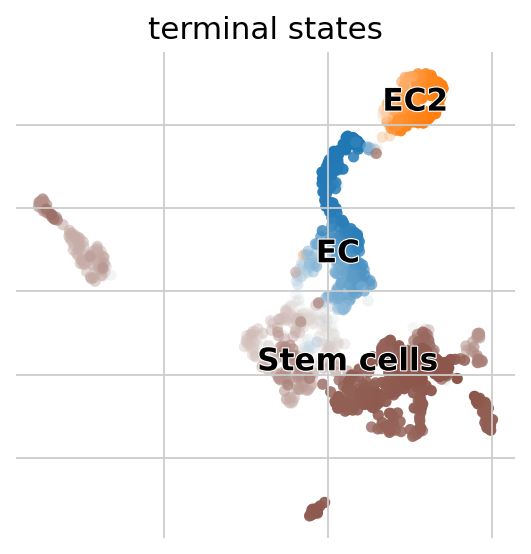

In [ ]:
#Identify terminal states
terminals=['EC2','EEc','GC']
cr.tl.terminal_states(adata, cluster_key='cell type')

##plot the terminal state
cr.pl.terminal_states(adata)



C:\Users\ahmed\AppData\Local\Temp\ipykernel_20036\1926411920.py:2: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="cell type")
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\cellrank\tl\_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/1171 [00:00<?, ?cell/s]

  0%|          | 0/1171 [00:00<?, ?cell/s]

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


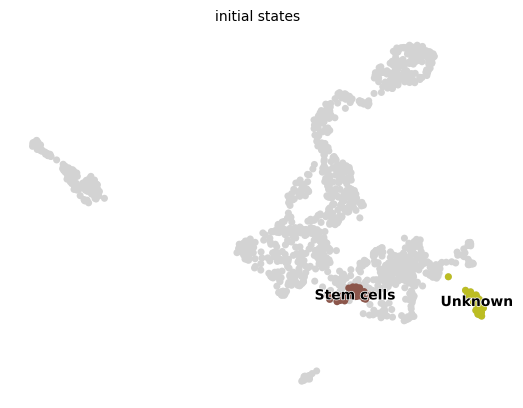

In [ ]:
#Identify initial_state
cr.tl.initial_states(adata, cluster_key="cell type")

##plot the initial_state
cr.pl.initial_states(adata,discrete=True)

# Compute fate maps
Once we know the terminal states, we can compute associated fate maps - for each cell, we ask how likely is the cell to develop towards each of the identified terminal states.

Defaulting to `'gmres'` solver.


C:\Users\ahmed\AppData\Local\Temp\ipykernel_20036\1878844763.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)


  0%|          | 0/3 [00:00<?, ?/s]

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


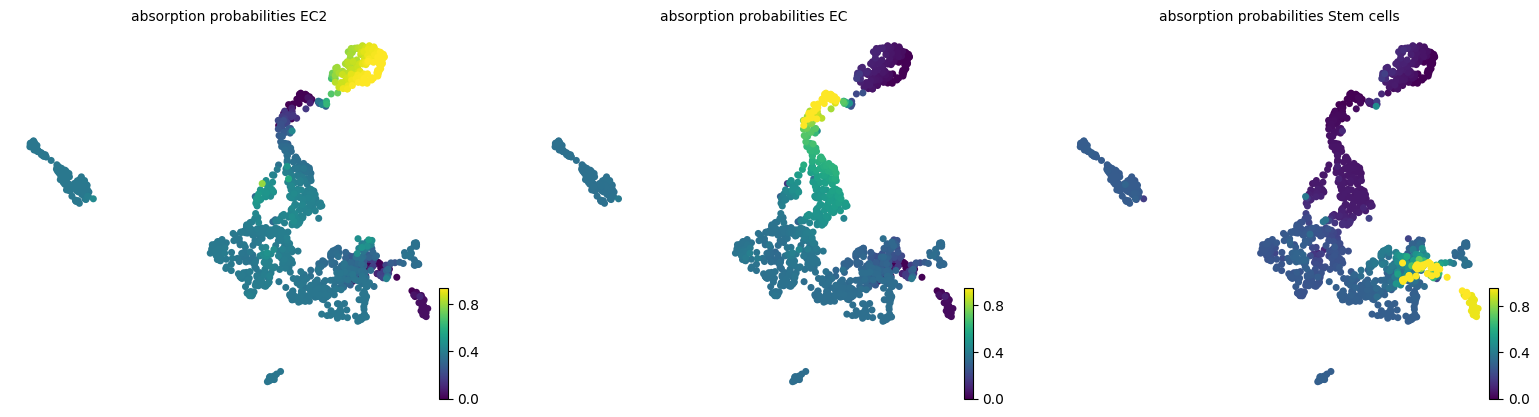

In [ ]:
cr.tl.lineages(adata)##calculate cell to cell transition probabilties
cr.pl.lineages(adata, same_plot=False)

C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
C:\Users\ahmed\miniconda3\envs\my_project\lib\site-packages\scvelo\plotting\scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


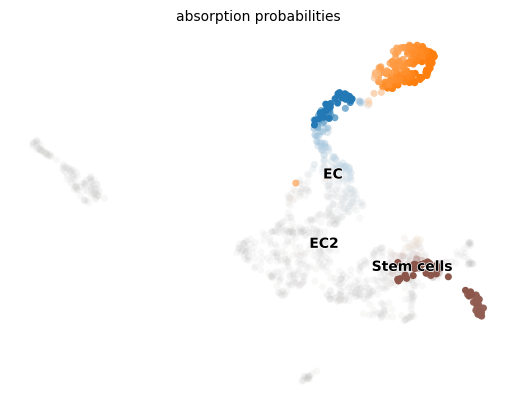

In [ ]:
cr.pl.lineages(adata, same_plot=True)

In [ ]:
adata

AnnData object with n_obs × n_vars = 1171 × 1701
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs', 'clusters_gradients', 'initial_states', 'initial_states_probs'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
 

In [ ]:
adata.obsm['to_terminal_states']

Lineage([[0.86716782, 0.06575152, 0.06708527],
         [0.38849995, 0.36417521, 0.24733223],
         [0.37599981, 0.34675454, 0.27725361],
         ...,
         [0.37490777, 0.56734493, 0.05775169],
         [0.        , 0.        , 1.        ],
         [0.37438531, 0.34621431, 0.27940925]],
  names([EC2, EC, Stem cells]))

# Velorama

In [ ]:
target_genes = pd.read_csv("potenial driver.csv")
print(target_genes.head())
print(target_genes.shape)

   Unnamed: 0       EC        EC2     EEc     GC       GC2 Stem cells  \
0           0   Prss30  Serpinb6b  Sez6l2  Fcgbp     Capn9    Tmem45b   
1           1  Slc37a2      Klra7  Kcnmb2  Ptprr  Ccnb1ip1      Gna14   
2           2   Nlrp9b      Fstl1     Cpe   Plk1    Ahnak2      Hells   
3           3   Guca2a       Ly6m   Gfra3  Sval1    Fer1l6       Kif4   
4           4  Sectm1b    Adamts4    Chga  Kif11   Gadd45a     Ccdc34   

        TA      TA2 Unknown  
0    Muc13    Tnni1   Alas2  
1    Sgo2a  Cyp2c68    Bpgm  
2   Iqgap3    Myh14    Cdr2  
3  Depdc1a     Tgm3    Lad1  
4    Cdca8   Mgat4a    Tsr1  
(100, 10)


In [ ]:
adata.var_names

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Lactb2', 'Stau2', 'Tmem70', 'Paqr8', 'Gsta3', 'Fam135a', 'Prim2',
       'Dst', 'Plekhb2', 'Neurl3',
       ...
       'Vsig1', 'Tmem164', 'Alas2', 'Phf8', 'Txlng', 'Ctps2', 'Zrsr2', 'Pir',
       'Mid1', 'AC149090.1'],
      dtype='object', length=1701)

In [ ]:
# We need to choose a set of potential regulator genes; for now we will use ALL genes as potential regulators.
target_genes = target_genes.head(10) # use the top 10 potential drivers
regulator_genes = adata.var_names # all genes = potential regulators for now
adata.var['is_reg'] = [n in regulator_genes for n in adata.var.index.values]
adata.var['is_target'] = [n in target_genes for n in adata.var.index.values]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Run velorama
!velorama -ds $adata.h5ad -dyn $rna_velocity -dev $cuda -l $L -hd $32 -rd $RNA_Velocity

usage: velorama
       [-h]
       [-n NAME]
       [-ds DATASET]
       [-dyn {pseudotime,rna_velocity}]
       [-dev DEVICE]
       [-s SEED]
       [-lmr LAM_RIDGE]
       [-p PENALTY]
       [-l LAG]
       [-hd HIDDEN]
       [-mi MAX_ITER]
       [-lr LEARNING_RATE]
       [-pr PROBA]
       [-ce CHECK_EVERY]
       [-rd ROOT_DIR]
       [-ls LAM_START]
       [-le LAM_END]
       [-xn {none,zscore,to_count:zscore}]
       [-nl NUM_LAMBDAS]
velorama: error: argument -dyn/--dyn: expected one argument
